# Astana Real Estate Price Estimation 

## Table of contents

1. [Introduction](#Introduction)

2. [Required libraries](#Required-libraries)

3. [Data Parsing](#Data-Parsing)

4. [Raw Data Processing](#Raw-Data-Processing)

5. [Handling Missing Values and Feature Engineering](#Handling-Missing-Values-and-Feature-Engineering)

6. [Exploratory analysis](#Exploratory-analysis)

7. [Encoding and data preparation for training](#Encoding-and-data-preparation-for-training)

8. [Feature and Model Selection](#Feature-and-Model-Selection)

9. [Conclusions](#Conclusions)

10. [Functions for downloading and preprocessing new data for model retraining](#Functions-for-downloading-and-preprocessing-new-data-for-model-retraining)

## Introduction

[[ go back to the top ]](#Table-of-contents)   


Welcome to my Notebook for Real Estate Price Estimation in Astana!

In this notebook, I present a comprehensive approach to estimating real estate prices in Astana, Kazakhstan. Leveraging the power of Python and various libraries, I have developed a robust system that utilizes data from multiple sources to provide accurate price predictions.

Throughout the implementation, I incorporated the following key components:

* Data Acquisition from krisha.kz:
I gathered extensive real estate data from krisha.kz, one of the leading platforms for property listings in Kazakhstan. This data serves as the foundation for my price estimation model, encompassing a wide range of properties across Astana.

* Geocoding with 2GIS:
Utilizing geocoding services provided by 2GIS, I accurately pinpoint the geographical locations of properties within Astana. This crucial step enables me to incorporate spatial information into my analysis, enhancing the precision of my price estimations.

* Distance Calculation using Geopy:
By employing the Geopy library, I calculate distances between properties and various amenities, landmarks, and essential facilities in Astana. This feature adds value to my price estimations by considering proximity to key locations, which significantly influences property values.

* Information Retrieval from kn.kz:
Extracting pertinent details about residential complexes from kn.kz, I enrich my dataset with additional insights into neighborhood characteristics, amenities, and community features. This information contributes to a more comprehensive understanding of the factors affecting property prices in Astana.

By synergizing these tools and data sources, my notebook offers a sophisticated solution for estimating real estate prices in Astana. Through detailed code demonstrations and insightful analysis, I aim to provide valuable insights to stakeholders in the Astana housing market.

Let's dive into the code and explore the fascinating world of real estate price estimation in Astana!

## Required libraries

[[ go back to the top ]](#Table-of-contents)   


<font color='green'>In this section, we'll import the necessary libraries and will do seeding, versioning.</font>

In [1]:
# External libraries
import re
import ast
import time
import math
import datetime
import pickle
import csv
import warnings

# Data manipulation libraries and visualization libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

# For working with geodata
from geopy.distance import geodesic

# Web scraping and API libraries
import requests
import json
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Initialize Comet ML experiment
from comet_ml import Experiment
experiment = Experiment(api_key="4qpFa2bX1fKJGNJFu5RGSDbSJ", project_name="astana-real-estate-price-estimation")

# Encoding categorical features
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Statistical analysis and modeling
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, learning_curve, KFold
from scipy.stats import uniform, randint
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import  make_scorer
from hyperopt import hp, fmin, tpe, Trials
import optuna

# Data mining and processing utilities
from data_mining import (
    parse_data_from_krisha, preprocess_krisha_df, parse_data_from_kn, preprocess_complex_df, 
    find_missing_complexes, second_preprocess_complex_df, second_preprocess_krisha_df, 
    geocode_2gis, process_and_clean_data, count_places_within_radius, checking_park, 
    save_data, read_data, decision_normality, decision_hypothesis, mean_relative_error, 
    plot_learning_curve
)

# Committing RANDOM_SEED to make experiments repeatable
SEED = 42

# Committing the package version to make the experiments repeatable
!pip freeze > requirements.txt

# Set visualization theme
sns.set_theme("notebook") 
sns.set_palette("Set2")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/zhaneiro/astana-real-estate-price-estimation/c2cd0543f4ba48c7ae6271a76a14f038



## Data Parsing


[[ go back to the top ]](#Table-of-contents)   


<font color='green'>In this section, we'll parse the data from its source.</font>

In [2]:
# # Parsing data from Krisha website with a limit of 1000 entries
# krisha_df_rought = parse_data_from_krisha(1000)

# # Saving the rough parsed data to a file to prevent data loss after parsing
# save_data(krisha_df_rought, 'krisha_df_rought')

# Reading the rough parsed data from the saved file 
krisha_df_rought = read_data('krisha_df_rought')
print(f'The number of rows in krisha_df_rought: {krisha_df_rought.shape[0]}')
krisha_df_rought.head(3)

The number of rows in krisha_df_rought: 20074


,name,information,address,price,owner
0,"3-комнатная квартира, 77 м², 1/4 этаж","2018 г.п., санузел раздельный, ✅Полноценная 3 ...","Есильский р-н, Е 496 10",33 000 000 〒,Риелтор
1,"1-комнатная квартира, 40 м², 3/14 этаж","жил. комплекс Jetisu.Lepsi, монолитный дом, 20...","Есильский р-н, Улы Дала — Ұлы дала",21 000 000 〒,Риелтор
2,"1-комнатная квартира, 43.8 м², 6/18 этаж","жил. комплекс BURABAY, монолитный дом, 2022 г....","Алматы р-н, Ж. Нажимеденова 62 — А62",18 500 000 〒,Риелтор


In [6]:
# # Parsing data from KN website
# complex_df_rought = parse_data_from_kn()

# # Saving the rough parsed data to a file to prevent data loss after parsing
# save_data(complex_df_rought, 'complex_df_rought')

# Reading the rough parsed data from the file 'complex_df_rought.csv'
complex_df_rought = read_data('complex_df_rought')
print(f'The number of rows in complex_df_rought: {complex_df_rought.shape[0]}')
complex_df_rought.head(3)

The number of rows in complex_df_rought: 1076


,complex_name,city_district,address,year,developer,characteristics
0,ЖК Шыгыс,"Астана, р-н Нура","ул. Сыганак, 14",2017 г.,ASI,"{'Класс ЖК': 'эконом', 'Умный дом': 'нет', 'Вы..."
1,ЖК Mechta,"Астана, р-н Нура","ул. Култегин, 11",2022 г.,Паркинг Системс Астана,"{'Класс ЖК': 'комфорт', 'Умный дом': 'нет', 'В..."
2,ЖК Sat City,"Астана, р-н Нура","ул. Асфендиярова, 8",2021 г.,SAT-NS,"{'Класс ЖК': 'комфорт', 'Умный дом': 'нет', 'В..."


## Raw Data Processing

[[ go back to the top ]](#Table-of-contents)   


<font color='green'>The preprocess consists of two stages 
* Extracting key data from collected information
* Unification of complex names in two tables for the next mergening</font>

In [3]:
krisha_df_rought = preprocess_krisha_df(krisha_df_rought)
display(krisha_df_rought.head(3))

,name,information,address,price,owner,complex_name,house_type,in_pledge,construction_year,ceiling_height,furniture_info,bathroom_info,condition,area,room_count,floor,floor_count,district
0,"3-комнатная квартира, 77 м², 1/4 этаж","2018 г.п., санузел раздельный, ✅Полноценная 3 ...",Е 496 10,33000000,Риелтор,NaN,None,False,2018,NaN,NaN,раздельный,NaN,77.0,3,1,4,Есильский р-н
1,"1-комнатная квартира, 40 м², 3/14 этаж","жил. комплекс Jetisu.Lepsi, монолитный дом, 20...",Улы Дала,21000000,Риелтор,jetisu.lepsi,монолитный дом,False,2023,3.0,частично мебели,совмещенный,хорошее,40.0,1,3,14,Есильский р-н
2,"1-комнатная квартира, 43.8 м², 6/18 этаж","жил. комплекс BURABAY, монолитный дом, 2022 г....",Ж. Нажимеденова 62,18500000,Риелтор,burabay,монолитный дом,False,2022,2.7,NaN,совмещенный,NaN,43.8,1,6,18,Алматы р-н


In [4]:
krisha_df_rought.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17144 entries, 0 to 17143
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               17144 non-null  object 
 1   information        17144 non-null  object 
 2   address            17144 non-null  object 
 3   price              17144 non-null  object 
 4   owner              17144 non-null  object 
 5   complex_name       12743 non-null  object 
 6   house_type         14864 non-null  object 
 7   in_pledge          17144 non-null  bool   
 8   construction_year  17144 non-null  int64  
 9   ceiling_height     14828 non-null  float64
 10  furniture_info     1158 non-null   object 
 11  bathroom_info      11647 non-null  object 
 12  condition          10645 non-null  object 
 13  area               17144 non-null  float64
 14  room_count         17144 non-null  int64  
 15  floor              15675 non-null  object 
 16  floor_count        156

In [7]:
complex_df_rought = preprocess_complex_df(complex_df_rought)
display(complex_df_rought.head(3))

,complex_name,city_district,address,year,developer,complex_class,ceiling_height,house_type,floor_count,parking,elevator,heating
0,шыгыс,"Астана, р-н Нура","ул. Сыганак, 14",2017 г.,ASI,эконом,2.7 м,монолитно-каркасная,7 – 16,надземный,"пассажирский и грузовой, пассажирский",центральное
1,mechta,"Астана, р-н Нура","ул. Култегин, 11",2022 г.,Паркинг Системс Астана,комфорт,3 м,кирпичная,10,надземный,пассажирский,центральное
2,sat city,"Астана, р-н Нура","ул. Асфендиярова, 8",2021 г.,SAT-NS,комфорт,3 м,монолитно-каркасная,12 – 18,надземный,пассажирский и грузовой,NaN


In [8]:
complex_df_rought.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   complex_name    1076 non-null   object
 1   city_district   1076 non-null   object
 2   address         1076 non-null   object
 3   year            1075 non-null   object
 4   developer       1027 non-null   object
 5   complex_class   1073 non-null   object
 6   ceiling_height  1070 non-null   object
 7   house_type      1076 non-null   object
 8   floor_count     1076 non-null   object
 9   parking         917 non-null    object
 10  elevator        1056 non-null   object
 11  heating         804 non-null    object
dtypes: object(12)
memory usage: 101.0+ KB


In [ ]:
# Finding the missing complex names in complex_df or their names differed 
find_missing_complexes(krisha_df_rought, complex_df_rought)

Number of complexes from the complex_df that do not match with complexes in the krisha_df or absent: 179
List of these complexes: ['сатти 7', 'мжк астана', '7я', 'феникс', 'vip городок саранда', 'толенды', 'алтын булак', 'абылайхан', 'бронкс', 'орынбор', 'отан 2', 'арлан', 'времена года. весна', 'sezim qala.senim', 'озен', 'абылайхан 2', 'сказка по ул. сейфулина', 'сарайшик', 'happy land', 'greenline.terra', 'апарт отель yes astana', 'жилой дом по ул. айнакол', 'сан сити', 'акбулак nak', 'кулан 2', 'kinghouse', 'сармат 2', 'capital park.flowers', 'алтын шар 1', 'ala tau comfort', 'лея за рекой', 'sezim qala.baqyt', 'кок жайлау', 'баскару 1', 'arman deluxe', 'гулдер', 'sclub', 'есиль (бокейхана', 'нипи 2', 'greenline.asyl mura', 'биик шанырак', '3 гектара', 'орбита 2', 'бигвилль поколение', 'greenline.aqua', 'меркурий 2', 'городской романс', 'greenline.asyl mura jubanov', 'арман тау', 'бахыт премиум', 'zhana omir', 'сармат 1', 'family village (кг)', 'ельтай', 'магистральный 2', 'елорда

In [8]:
# Correction of names of residential complexes in two tables so that later they can be combined as key words
# So addition of non-exhaustive housing complexes and correction some of data in complex_df
complex_df = second_preprocess_complex_df(complex_df_rought)
krisha_df = second_preprocess_krisha_df(krisha_df_rought)

# Cheking 
find_missing_complexes(krisha_df, complex_df)

Number of complexes from the complex_df that do not match with complexes in the krisha_df or absent: 1
List of these complexes: [nan]


### Parsing, preprocessing and additing new data

In [3]:
def parsing_addition_data(total_pages):
    """
    Parse data from the first page to the last page, preprocess it, and add it to the original DataFrame.

    Args:
    first_page (int): The first page number to start parsing from.
    last_page (int): The last page number to parse up to.
    krisha_df (pandas.DataFrame): The original DataFrame to which the parsed and preprocessed data will be added.

    Returns:
    pandas.DataFrame: The updated DataFrame with parsed and preprocessed data added.
    """
    
    # Function for parsing data from the first page to the last page
    addition_krisha_df_rought = parse_data_from_krisha(total_pages)
    
    # Preprocess the data
    addition_krisha_df_rought = preprocess_krisha_df(addition_krisha_df_rought)
    
    # Additional data preprocessing
    addition_krisha_df = second_preprocess_krisha_df(addition_krisha_df_rought)
    
    return addition_krisha_df

In [11]:
# # Apply the function to the DataFrame
# addition_krisha_df = parsing_addition_data(400)
# # Saving the rough parsed data to a file to prevent data loss after parsing
# save_data(addition_krisha_df, 'addition_krisha_df')

addition_krisha_df = read_data('addition_krisha_df')
print(f'The number of rows in addition_krisha_df: {addition_krisha_df.shape[0]}')

#  Adding additionally downloaded table to main table
krisha_df = pd.concat([krisha_df, addition_krisha_df], ignore_index=True)
krisha_df = krisha_df.drop_duplicates().reset_index(drop=True).copy()
display(krisha_df.info())

The number of rows in addition_krisha_df: 5120
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22256 entries, 0 to 22255
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               22256 non-null  object 
 1   information        22256 non-null  object 
 2   address            22244 non-null  object 
 3   price              22256 non-null  object 
 4   owner              22256 non-null  object 
 5   complex_name       16548 non-null  object 
 6   house_type         19231 non-null  object 
 7   in_pledge          22256 non-null  bool   
 8   construction_year  22256 non-null  int64  
 9   ceiling_height     19231 non-null  float64
 10  furniture_info     1463 non-null   object 
 11  bathroom_info      15076 non-null  object 
 12  condition          13764 non-null  object 
 13  area               22256 non-null  float64
 14  room_count         22256 non-null  int64  
 15  floor              2035

None

In [12]:
# Count missing values in the feature complex_name   
missing_values_count = krisha_df['complex_name'].isnull().sum()
print("Number of missing values in feature {}: {}".format('complex_name', missing_values_count))

Number of missing values in feature complex_name: 5708


## Handling Missing Values and Feature Engineering


[[ go back to the top ]](#Table-of-contents)    

<font color='green'>Here, we'll handle missing values, and create new features.</font>

### Geo-coding of addresses of residential complexes by using 2GIS in complex_df and creating new features based on coordinates. 

In [14]:
def geo_process_complex_df(complex_df):
    """
    Process complex dataframe by geocoding, parsing coordinates,and counting nearby places.
    For this purpose, dictionaries with names of schools, kindergartens, parks of Astana with coordinates are used.
    Args:
        complex_df (DataFrame): DataFrame containing complex information.

    Returns:
        DataFrame: DataFrame with created new 4 features.
    """
    # Geocoding and parsing coordinates
    complex_df['coordinates_2gis'] = complex_df['address'].apply(geocode_2gis)
    complex_df['coordinates_2gis'] = complex_df['coordinates_2gis'].apply(lambda x: ast.literal_eval(x))
    complex_df['schools_within_1km'] = complex_df['coordinates_2gis'].apply(lambda x: count_places_within_radius('school', x, 1000))
    complex_df['kindergartens_within_1km'] = complex_df['coordinates_2gis'].apply(lambda x: count_places_within_radius('kindergarten', x, 1000))
    complex_df['park_within_2km'] = complex_df['coordinates_2gis'].apply(lambda x: checking_park(x, 2000))
    
    return complex_df

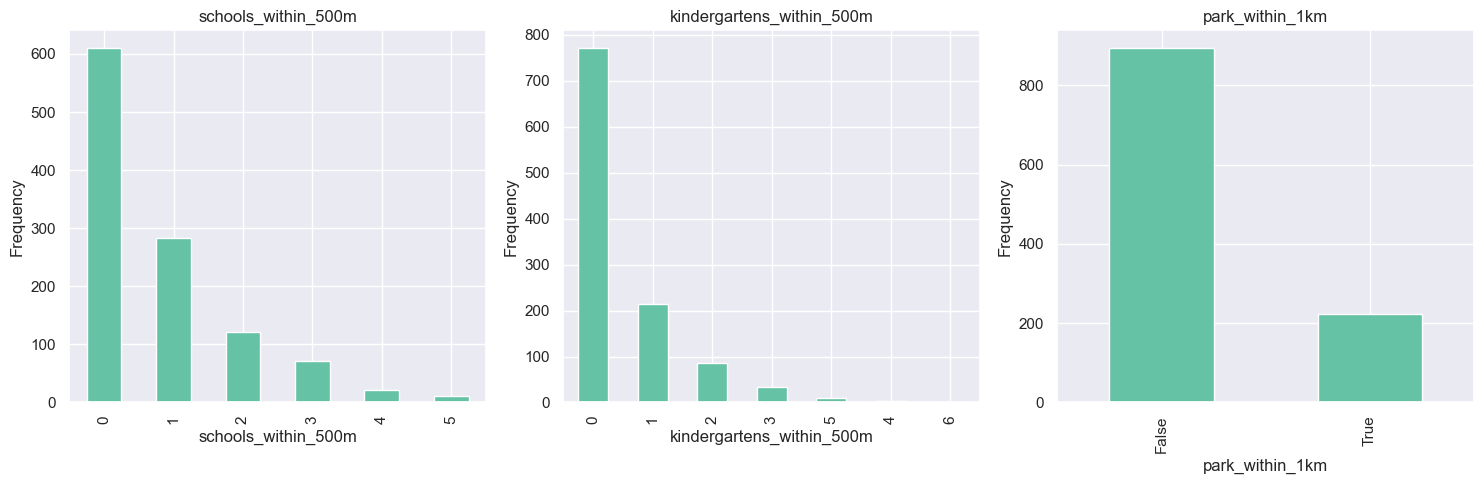

In [ ]:
# Apply the function to the DataFrame
complex_df = geo_process_complex_df(complex_df)
save_data(complex_df, 'complex_df')

# Visualization of newly created cat features with the help of coordinates
complex_df = read_data('complex_df')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
categorical_features = ['schools_within_500m', 'kindergartens_within_500m', 'park_within_1km']

for i, ax in enumerate(axes):
    category_counts = complex_df[categorical_features[i]].value_counts()
    category_counts.plot(kind='bar', ax=ax)
    ax.set_title(categorical_features[i])
    ax.set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()


### Geo-coding of the addresses of those apartments at which the name of the residential complex is not known and search for the name of residential complexes through coordinates

In [25]:
def geo_process_krisha_df(krisha_df):
    
    # Geocoding addresses of rows that doesn't have 'complex_name' by using geocode_2gis function
    indexes = krisha_df[krisha_df.complex_name.isna()].index
    krisha_df.loc[indexes, 'coordinates_2gis'] = krisha_df.loc[indexes, 'address'].apply(geocode_2gis)
    
    return krisha_df

def filling_complex_names_in_krisha_df(krisha_df):
    
    # Get the indexes where 'complex_name' is NaN
    indexes = krisha_df[krisha_df.complex_name.isna()].index
    
    # First stage of filling in missing values in the 'complex_name' feature
    # Using a dictionary created from coordinates and names of residential complexes, we find identical coordinates in the krisha_df table
    complex_df = pd.read_csv('data/complex_df.csv')
    dict_found_pair = complex_df[['coordinates_2gis', 'complex_name']].set_index('coordinates_2gis')['complex_name'].to_dict()
    
    # Fill NaN 'complex_name' with values from 'coordinates_2gis' dictionary if their coordinates match
    krisha_df.loc[indexes, 'complex_name'] = krisha_df.loc[indexes, 'coordinates_2gis'].map(dict_found_pair)

    krisha_df['coordinates_2gis'] = krisha_df['coordinates_2gis'].apply(lambda x: str(x) if not pd.isnull(x) else np.nan)
    krisha_df['coordinates_2gis'] = krisha_df['coordinates_2gis'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else None)
    complex_df['coordinates_2gis'] = complex_df['coordinates_2gis'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else None)
    
    # Second stage of filling in missing values in the 'complex_name' feature
    # Using the function, we find residential complexes within a radius of 400 meters, 
    # and if the type of building and the year of construction match
    def matching_house_search_in_radius(row, df_complex):
        if pd.isnull(row['complex_name']):
            coordinates = row['coordinates_2gis']
            house_type = row['house_type']
            construction_year = row['construction_year']
            floor_count = row['floor_count']
            
            if coordinates is None:
                return None
            else:
                nearest_complex = None
                min_distance = float('inf')  # Initializing the minimum distance with infinity
                
                for idx, row_complex in df_complex.iterrows():
                    distance = geodesic(coordinates, row_complex['coordinates_2gis']).meters
                    complex_year = row_complex.get('year')  # Getting the construction year of the complex
                    complex_house_type = row_complex.get('house_type')  # Getting the building type of the complex
                    min_complex_floor = row_complex.get('min_floor_count')  # Minimum floor of the complex
                    max_complex_floor = row_complex.get('max_floor_count') + 1  # Maximum floor of the complex + 1
                    
                    if (pd.isnull(floor_count) or min_complex_floor <= floor_count <= max_complex_floor) and \
                            (pd.isnull(house_type) or complex_house_type == house_type) and \
                            abs(complex_year - construction_year) <= 3 and \
                            distance <= 400 : # radius 400 metrs
                        if distance < min_distance:
                            min_distance = distance
                            nearest_complex = row_complex['complex_name']
                            
                return nearest_complex
        else:
            return row['complex_name'] 
    
    
    # Applying the function to fill missing values in the 'complex_name' column
    krisha_df['complex_name'] = krisha_df.apply(lambda row: matching_house_search_in_radius(row, complex_df), axis=1)

    return krisha_df

In [ ]:
# Applying the first function 
krisha_df  = geo_process_krisha_df(krisha_df)

# Applying the seconf function 
krisha_df = filling_complex_names_in_krisha_df(krisha_df)

# Saving data
save_data(krisha_df, 'krisha_df')

display(krisha_df.head(3))

,name,information,address,price,owner,complex_name,house_type,in_pledge,construction_year,ceiling_height,furniture_info,bathroom_info,condition,area,room_count,floor,floor_count,district,coordinates_2gis
0,"3-комнатная квартира, 77 м², 1/4 этаж","2018 г.п., санузел раздельный, ✅Полноценная 3 ...",Е 496 10,33000000,Риелтор,kemel,NaN,False,2018,NaN,NaN,раздельный,NaN,77.0,3,1.0,4.0,Есильский р-н,"(51.073887, 71.427446)"
1,"1-комнатная квартира, 40 м², 3/14 этаж","жил. комплекс Jetisu.Lepsi, монолитный дом, 20...",Улы Дала — Ұлы дала,21000000,Риелтор,jetisu.lepsi,монолитный дом,False,2023,3.0,частично мебели,совмещенный,хорошее,40.0,1,3.0,14.0,Есильский р-н,NaN
2,"1-комнатная квартира, 43.8 м², 6/18 этаж","жил. комплекс BURABAY, монолитный дом, 2022 г....",Ж. Нажимеденова 62 — А62,18500000,Риелтор,burabay,монолитный дом,False,2022,2.7,NaN,совмещенный,NaN,43.8,1,6.0,18.0,Алматы р-н,NaN


<blockquote style="font-size: 20px; color: green;">
Using this approach, I managed to fill in over 2,000 missing values in the complex names.
</blockquote>

### Mergering two tables by the name of the residential complex 

In [5]:
def merge_dataframes(krisha_df):
    """
    Merge two DataFrames based on the 'complex_name' column.

    Args:
    krisha_df_path (str): Path to the CSV file containing the Krisha DataFrame.
    complex_df_path (str): Path to the CSV file containing the Complex DataFrame.

    Returns:
    pandas.DataFrame: Merged DataFrame containing data from both DataFrames.
    """
    complex_df = pd.read_csv('data/complex_df.csv')
    
    merged_df = pd.merge(left=krisha_df, right=complex_df, on='complex_name', how='left', suffixes=('', '_complex'))
    
    return merged_df

In [ ]:
# Reading the table for reproducibility
krisha_df = read_data('krisha_df')

# Applying the function 
merged_df = merge_dataframes(krisha_df)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20668 entries, 0 to 20667
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       20668 non-null  object 
 1   information                20668 non-null  object 
 2   address                    20645 non-null  object 
 3   price                      20668 non-null  int64  
 4   owner                      20668 non-null  object 
 5   complex_name               17719 non-null  object 
 6   house_type                 17951 non-null  object 
 7   in_pledge                  20668 non-null  bool   
 8   construction_year          20668 non-null  int64  
 9   ceiling_height             17797 non-null  float64
 10  furniture_info             1356 non-null   object 
 11  bathroom_info              13865 non-null  object 
 12  condition                  12782 non-null  object 
 13  area                       20668 non-null  flo

None

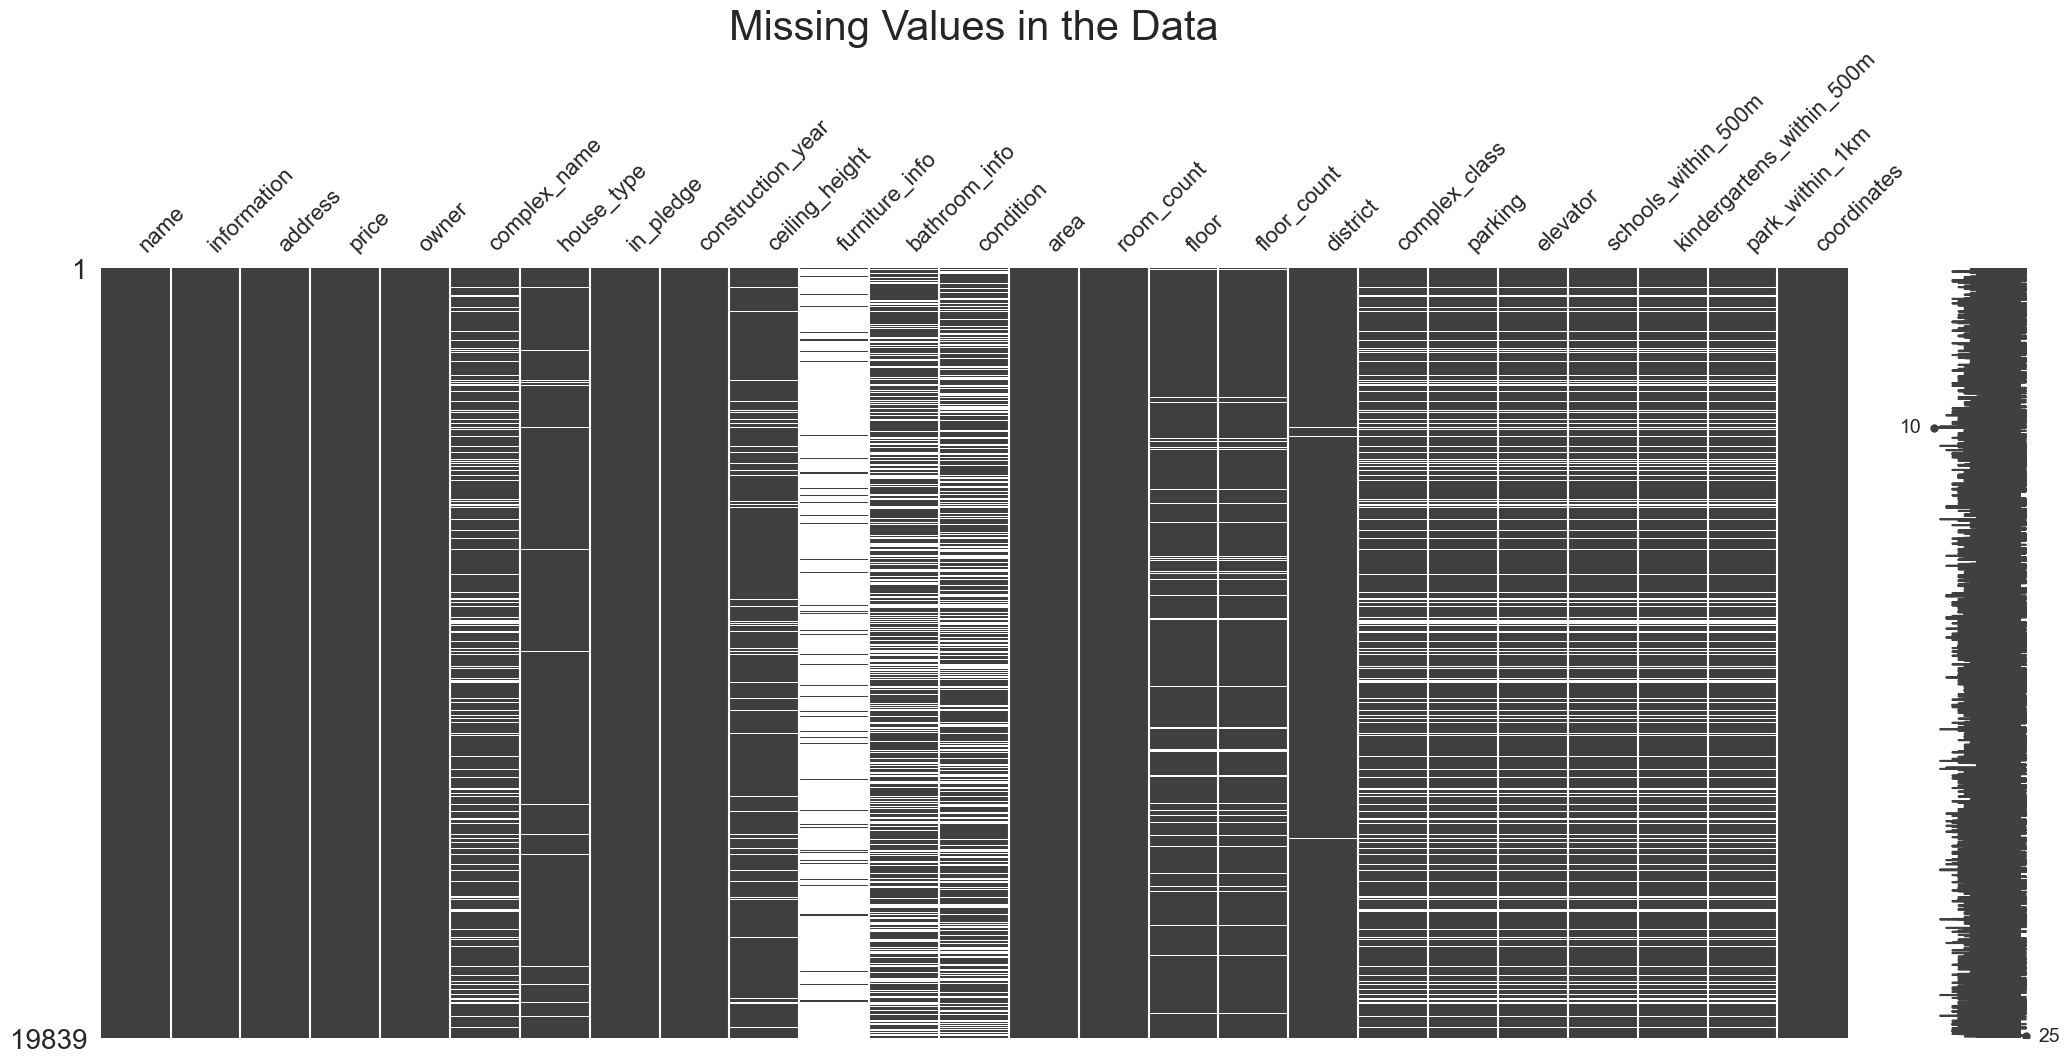

In [ ]:
# Combining the same features to fill in passages in them, removing unnecessary columns from the second table, etc
merged_df = process_and_clean_data(merged_df)

# Visualize missing values in the DataFrame
msno.matrix(merged_df)
plt.title('Missing Values in the Data', fontsize=30)
plt.show()

### Filling in the geo-features using the same functions as the complex_df, and creating new features regarding distance.

In [6]:
def geo_preprocess_merged_df(merged_df):
    
    # Convert string representations of coordinates to coordinate lists
    merged_df = merged_df.dropna(subset=['coordinates']).reset_index(drop=True)
    merged_df['coordinates'] = merged_df['coordinates'].astype(str)
    merged_df['coordinates'] = merged_df['coordinates'].apply(lambda x: ast.literal_eval(x) if not pd.isnull(x) else None)
    
    # Filling missing values
    
    
    # Fill missing values for nearby parks within 1 kilometer
    null_index = merged_df[merged_df['park_within_1km'].isna()].index
    merged_df.loc[null_index, 'park_within_1km'] = merged_df.loc[null_index, 'coordinates'].apply(lambda x: checking_park(x, 2000))
    
    # Fill missing values for nearby schools within 500m
    null_index = merged_df[merged_df['schools_within_500m'].isna()].index
    merged_df.loc[null_index, 'schools_within_500m'] = merged_df.loc[null_index, 'coordinates'].apply(lambda x: count_places_within_radius('school', x, 1000))

    # Fill missing values for nearby kindergartens within 500m
    null_index = merged_df[merged_df['kindergartens_within_500m'].isna()].index
    merged_df.loc[null_index, 'kindergartens_within_500m'] = merged_df.loc[null_index, 'coordinates'].apply(lambda x: count_places_within_radius('kindergarten', x, 1000))
    
    # Creating new features 

    # Taking 'Baiterek Monument' as the geographical center
    geo_center_of_astana = (51.128318, 71.430381)
    merged_df['distance_to_center'] = merged_df['coordinates'].apply(lambda x: geodesic(geo_center_of_astana, x).kilometers)

    # Distances to Botanical Garden
    botanical_garden = (51.106433, 71.416329)
    merged_df['distance_to_botanical_garden'] = merged_df['coordinates'].apply(lambda x: geodesic(botanical_garden, x).kilometers)

    # Distances to Triathlon Park
    triathlon_park = (51.13593, 71.449809)
    merged_df['distance_to_triathlon_park'] = merged_df['coordinates'].apply(lambda x: geodesic(triathlon_park, x).kilometers)

    # Distances to Astana Park
    astana_park = (51.156264, 71.419961)
    merged_df['distance_to_astana_park'] = merged_df['coordinates'].apply(lambda x: geodesic(astana_park, x).kilometers)

    # Distances to Treatment Facility
    treatment_facility = (51.144302, 71.337247)
    merged_df['distance_to_treatment_facility'] = merged_df['coordinates'].apply(lambda x: geodesic(treatment_facility, x).kilometers)

    # Distances to First Railway Station
    railway_station_1 = (51.195572, 71.409173)
    merged_df['distance_to_railway_station_1'] = merged_df['coordinates'].apply(lambda x: geodesic(railway_station_1, x).kilometers)

    # Distances to Second Railway Station
    railway_station_2 = (51.112488, 71.531596)
    merged_df['distance_to_railway_station_2'] = merged_df['coordinates'].apply(lambda x: geodesic(railway_station_2, x).kilometers)

    # Distances to Industrial Zone
    industrial_zone = (51.140231, 71.551219)
    merged_df['distance_to_industrial_zone'] = merged_df['coordinates'].apply(lambda x: geodesic(industrial_zone, x).kilometers)


    return merged_df

In [ ]:
# Applying the function 
merged_df = geo_preprocess_merged_df(merged_df)

###  Last stage of feature engineering

In [7]:
def create_additional_features(df):
    """
    Processed DataFrame with additional engineered features such as 
    'kzt_sq_m', 'last_floor', and 'first_floor'.
    """
    # Compute price per square meter in Kazakhstani Tenge (KZT)
    # We will need it for predicting missing values in features using a random forest,
    # as well as for data analysis. In the end, we will remove it.
    df['kzt_sq_m'] = df['price'] / df['area']

    # Identify if the apartment is on the last floor
    df['last_floor'] = df['floor'] == df['floor_count']

    # Identify if the apartment is on the first floor 
    # Presumably, if the apartment is on the second floor and the residential complex has a underground, 
    # then from the courtyard it is also considered the first floor.
    df['first_floor'] = (df['floor'] == 1) | ((df['floor'] == 2) & (df['parking'] == 'underground'))

    return df

In [ ]:
# Applying the function 
merged_df = create_additional_features(merged_df)

### Manually filling missing values, as well as using Random Forest Classifier for imputation

In [8]:
def manual_data_imputation(df):
    """
    Imputes missing data in the DataFrame manually based on specified conditions.
    Changes were made for houses built before 2000
    At the end, lines containing missings in the following features were deleted
    ['house_type', 'ceiling_height', 'floor_count', 'district', 'floor', 'floor_count']
    
    Args:
        df (DataFrame): The DataFrame containing the data to be imputed.

    Returns:
        DataFrame: The DataFrame with some missing data imputed and cleaned.
    """
    
    # Checking for missing complex names
    missing_complex_name = df.complex_name.isna()

    # Imputing data based on specific conditions
    condition = (df.construction_year <= 2000) & (missing_complex_name)
    df.loc[condition, 'complex_class'] = 'economy'
    df.loc[condition, 'parking'] = 'no'
    df.loc[condition & (df.floor_count <= 6), 'elevator'] = 'no'
    df.loc[condition & (df.floor_count > 6), 'elevator'] = 'yes'

    condition = (df.construction_year < 1964) & (df.floor_count < 5) & missing_complex_name 
    df.loc[condition, 'complex_name'] = 'cталинка'

    condition = (df.construction_year < 1964) & (df.floor_count < 5) & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 3.0

    condition = (df.construction_year < 1964) & (df.floor_count < 5) & (df.house_type.isna())
    df.loc[condition, 'house_type'] = 'brick'

    condition = (df.construction_year < 1970) & (df.floor_count == 5) & missing_complex_name
    df.loc[condition, 'complex_name'] = 'хрущёвка'

    condition = (df.construction_year < 1970) & (df.bathroom_info == 'combined') & missing_complex_name
    df.loc[condition, 'complex_name'] = 'хрущёвка'

    condition = (df.construction_year < 1970) & (df.floor_count == 5) & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 2.5

    condition = df.construction_year.between(1964, 1982) & missing_complex_name
    df.loc[condition, 'complex_name'] = 'бережневка'

    condition = (df.construction_year > 1983) & (df.house_type == 'panel') & missing_complex_name
    df.loc[condition, 'complex_name'] = 'панелька нового типа'

    condition = (df.construction_year > 1983) & (df.house_type == 'panel') & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 2.7

    condition = (df.construction_year < 2000) & (df.house_type.isna())
    df.loc[condition, 'house_type'] = 'panel'

    condition = (df.construction_year < 2000) & (df.ceiling_height.isna())
    df.loc[condition, 'ceiling_height'] = 2.7

    df.loc[(df['complex_name'].isna()), 'complex_name'] = 'no name'

    # Dropping rows with missing values in certain columns
    columns_to_check = ['house_type', 'ceiling_height', 'floor_count', 'district', 'floor', 'floor_count']
    df = df.dropna(subset=columns_to_check)
    
    # Since there are a lot of missing values in the 'furniture_info' feature, we will remove it.
    df = df.drop(['furniture_info'], axis=1)
    
    return df


def fill_missing_by_rfc(merged_df, random_seed=42):
    """
    Fill missing values in the ['elevator', 'parking', 'complex_class'] using RandomForestClassifier.

    Parameters:
        merged_df (DataFrame): Input DataFrame with missing values.
        random_seed (int): Random seed for reproducibility. Default is 42.

    Returns:
        DataFrame: DataFrame with missing values filled.
    """

    df_filled = merged_df[['floor_count', 'room_count', 'area', 'ceiling_height', 'construction_year',
                           'elevator', 'parking', 'complex_class', 'house_type', 'district', 'kzt_sq_m']].copy()

    df_filled.fillna('missing', inplace=True)

    features = ['floor_count', 'room_count', 'area', 'ceiling_height', 'construction_year', 'house_type', 'district', 'kzt_sq_m']

    label_encoders = {}
    for column in df_filled.columns:
        if df_filled[column].dtype == 'object':
            unique_values = df_filled[column].unique().tolist() + ['missing']
            label_encoders[column] = LabelEncoder()
            label_encoders[column].fit(unique_values)
            df_filled[column] = label_encoders[column].transform(df_filled[column].astype(str))

    missing_rows = df_filled['elevator'].isin([label_encoders['elevator'].transform(['missing'])[0]]) | \
                   df_filled['parking'].isin([label_encoders['parking'].transform(['missing'])[0]]) | \
                   df_filled['complex_class'].isin([label_encoders['complex_class'].transform(['missing'])[0]])

    df_missing = df_filled[missing_rows]
    df_not_missing = df_filled[~missing_rows]

    X_train_elevator, _, y_train_elevator, _ = train_test_split(df_not_missing[features], df_not_missing['elevator'], stratify=df_not_missing['elevator'], test_size=0.1, random_state=random_seed)
    model_elevator = RandomForestClassifier(random_state=random_seed)
    model_elevator.fit(X_train_elevator, y_train_elevator)

    predicted_values_elevator = model_elevator.predict(df_missing[features])
    df_filled.loc[df_missing.index, 'elevator'] = predicted_values_elevator

    X_train_parking, _, y_train_parking, _ = train_test_split(df_not_missing[features], df_not_missing['parking'], stratify=df_not_missing['parking'], test_size=0.1, random_state=random_seed)
    model_parking = RandomForestClassifier(random_state=random_seed)
    model_parking.fit(X_train_parking, y_train_parking)

    predicted_values_parking = model_parking.predict(df_missing[features])
    df_filled.loc[df_missing.index, 'parking'] = predicted_values_parking

    X_train_complex, _, y_train_complex, _ = train_test_split(df_not_missing[features], df_not_missing['complex_class'], stratify=df_not_missing['complex_class'], test_size=0.1, random_state=random_seed)
    model_complex = RandomForestClassifier(random_state=random_seed)
    model_complex.fit(X_train_complex, y_train_complex)

    predicted_values_complex = model_complex.predict(df_missing[features])
    df_filled.loc[df_missing.index, 'complex_class'] = predicted_values_complex

    for column in label_encoders:
        df_filled[column] = label_encoders[column].inverse_transform(df_filled[column])

    merged_df['elevator'] = df_filled['elevator']
    merged_df['parking'] = df_filled['parking']
    merged_df['complex_class'] = df_filled['complex_class']

    return merged_df

In [ ]:
shape_before_cleaning = merged_df.shape[0]

# Applying the first function 
merged_df = manual_data_imputation(merged_df)

# Applying the second function 
merged_df = fill_missing_by_rfc(merged_df)

shape_after_cleaning = merged_df.shape[0]
print("Number of deleted rows: ", shape_before_cleaning - shape_after_cleaning)

Number of deleted rows:  1405


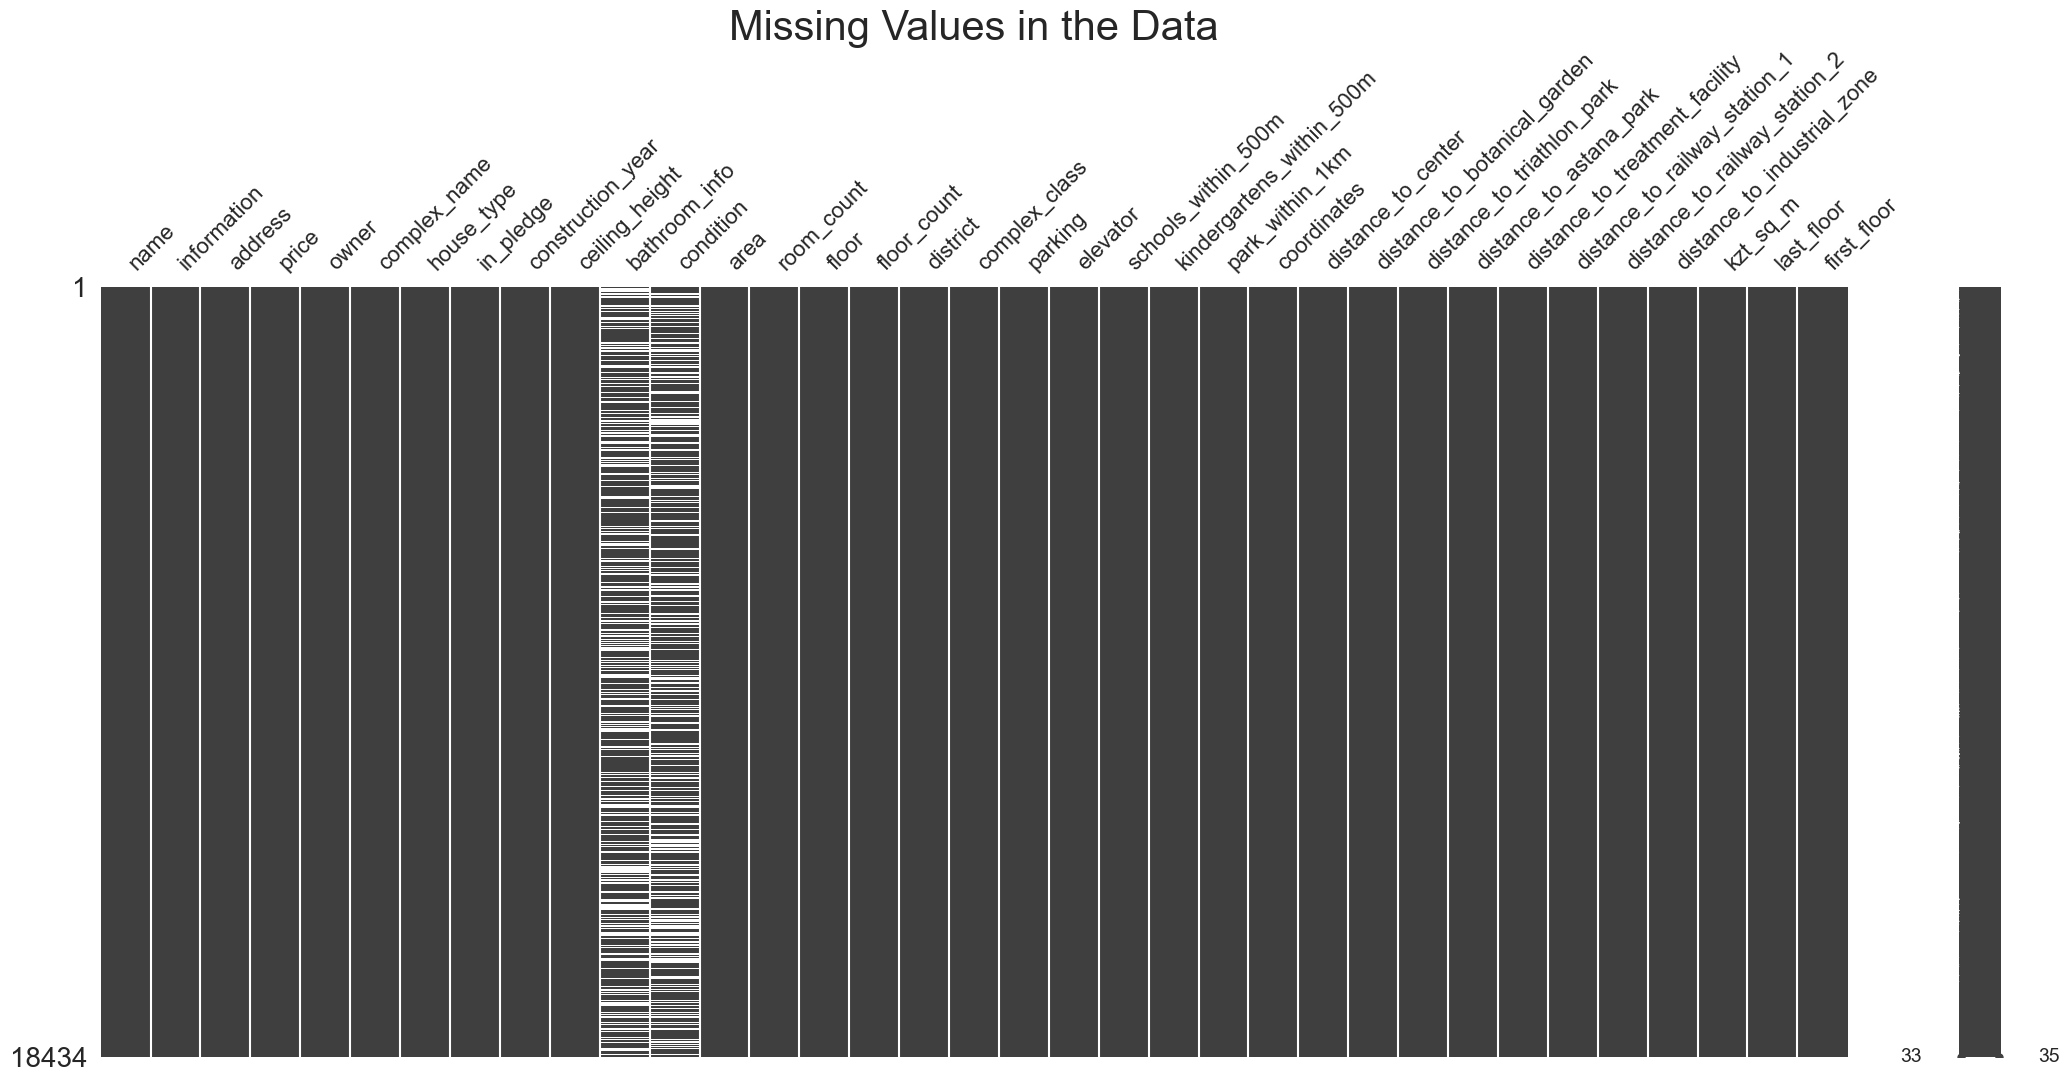

In [ ]:
save_data(merged_df, "merged_df")

# Visualize missing values in the DataFrame
msno.matrix(merged_df)
plt.title('Missing Values in the Data', fontsize=30)
plt.show()

<blockquote style="font-size: 20px; color: green;">
This two features with a large number of missings were decided to be kept for experimentation. They were explicitly marked as missing values and then trained on a CatBoostRegressor model.
</blockquote>

I decided to retain 'bathroom_info' and 'condition' and fill missing values with a special indicator -999 during encoding

## Exploratory analysis

[[ go back to the top ]](#Table-of-contents) 

<font color='green'>Let's look at the data that we have to analyse.

<table > 

   <tr>
    <th>Column</th>
    <th>Description</th>
    <th>Type</th>
  </tr>
  
   <tr>
    <td>price</td>
    <td>the total cost of the apartment</td>
    <td>int64</td>
  </tr>

   <tr>
    <td>owner</td>
    <td>ad from a realtor or from the property owner</td>
    <td>object</td>
  </tr>

   <tr>
    <td>complex_name</td>
    <td>name of residential complexes</td>
    <td>object</td>
  </tr>

   <tr>
    <td>house_type</td>
    <td>describes the materials used in the construction of the house</td>
    <td>object</td>
  </tr> 
    
  <tr>
    <td>in_pledge</td>
    <td>a boolean feature indicating whether the apartment is pledged or not</td>
    <td>bool</td>
  </tr>
    
  <tr>
    <td>construction_year</td>
    <td>the year of construction of the house</td>
    <td>int64</td>
  </tr>
    
   <tr>
    <td>ceiling_height</td>
    <td>the ceiling height in the apartment</td>
    <td>float64</td>
  </tr>

   <tr>
    <td>bathroom_info</td>
    <td>number of bathrooms in the apartment</td>
    <td>object</td>
  </tr>
    
   <tr>
    <td>condition</td>
    <td>the type of finishing in the apartment</td>
    <td>object</td>
  </tr> 
   
   <tr>
    <td>area</td>
    <td>the area of the apartment</td>
    <td>float64</td>
  </tr>  
    
   <tr>
    <td>room_count</td>
    <td>the number of rooms in the apartment</td>
    <td>int64</td>
  </tr>  
    
   <tr>
    <td>floor</td>
    <td>the floor on which the apartment is located</td>
    <td>int64</td>
  </tr> 
    
   <tr>
    <td>floor_count</td>
    <td>the number of floors in the building</td>
    <td>int64</td>
  </tr> 
    
  <tr>
    <td>district</td>
    <td>the name of the district where the building is located</td>
    <td>object</td>
  </tr> 

   <tr>
    <td>complex_class</td>
    <td>the housing class</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>parking</td>
    <td>information about the presence and type of parking</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>elevator</td>
    <td>information about the presence of an elevator in the building</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>schools_within_500m</td>
    <td>the number of schools within a radius of 500 meters</td>
    <td>float64</td>
  </tr> 
    
   <tr>
    <td>kindergartens_within_500m</td>
    <td>the number of kindergartens within a radius of 500 meters</td>
    <td>ifloat64</td>
  </tr> 
    
   <tr>
    <td>park_within_1km</td>
    <td>the presence of a park within a kilometer radius</td>
    <td>bool</td>
  </tr> 
    
   <tr>
    <td>coordinates</td>
    <td>the coordinates of the residential building (latitude, longitude)</td>
    <td>object</td>
  </tr> 
    
   <tr>
    <td>distance_to_center</td>
    <td>the distance to the city center in kilometers</td>
    <td>float64</td>
  </tr> 
    
   <tr>
    <td>distance_to_botanical_garden</td>
    <td>the distance to the botanical park in kilometers</td>
    <td>float64</td>
  </tr> 
 
   <tr>
    <td>distance_to_triathlon_park</td>
    <td>the distance to the triathlonl park in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_astana_park</td>
    <td>the distance to the central astana park in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_treatment_facility</td>
    <td>the distance to the waste treatment facility in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_railway_station_1</td>
    <td>the distance to the first railway station on the right bank in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_railway_station_2</td>
    <td>the distance to the second railway station on the left bank in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>distance_to_industrial_zone</td>
    <td>the distance to the industrial zone in kilometers</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>kzt_sq_m</td>
    <td>the price per square meter in Kazakh Tenge (KZT)</td>
    <td>float64</td>
  </tr>
  <tr>
    <td>last_floor</td>
    <td>a boolean feature indicating whether the floor is the last one or not</td>
    <td>bool</td>
  </tr>
  <tr>
    <td>first_floor</td>
    <td>a boolean feature indicating whether the floor is the first one or not</td>
    <td>bool</td>
  </tr>

</table>

</font>

### Finding outliers

In [29]:
df = read_data("merged_df")

df.head(3)

,name,information,address,price,owner,complex_name,house_type,in_pledge,construction_year,ceiling_height,...,distance_to_botanical_garden,distance_to_triathlon_park,distance_to_astana_park,distance_to_treatment_facility,distance_to_railway_station_1,distance_to_railway_station_2,distance_to_industrial_zone,kzt_sq_m,last_floor,first_floor
0,"3-комнатная квартира, 77 м², 1/4 этаж","2018 г.п., санузел раздельный, ✅Полноценная 3 ...",Е 496 10,33000000,agent,kemel,monolithic,False,2018,2.5,...,3.703569,7.077784,9.179456,10.063298,13.597845,8.466373,11.385081,428571.428571,False,True
1,"1-комнатная квартира, 40 м², 3/14 этаж","жил. комплекс Jetisu.Lepsi, монолитный дом, 20...",Улы Дала — Ұлы дала,21000000,agent,jetisu.lepsi,monolithic,False,2023,3.0,...,4.259391,5.519950,8.360829,11.188389,12.702507,5.137294,8.162841,525000.000000,False,False
2,"1-комнатная квартира, 43.8 м², 6/18 этаж","жил. комплекс BURABAY, монолитный дом, 2022 г....",Ж. Нажимеденова 62 — А62,18500000,agent,burabay,monolithic,False,2022,2.7,...,8.341438,6.716751,9.661737,14.427095,13.096655,0.503983,3.685814,422374.429224,False,False


,price,construction_year,ceiling_height,area,room_count,floor,floor_count,schools_within_500m,kindergartens_within_500m,distance_to_center,distance_to_botanical_garden,distance_to_triathlon_park,distance_to_astana_park,distance_to_treatment_facility,distance_to_railway_station_1,distance_to_railway_station_2,distance_to_industrial_zone,kzt_sq_m
count,1.843400e+04,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,18434.000000,1.843400e+04
mean,3.753080e+07,2014.570956,2.845770,68.830407,2.150754,6.672073,11.482315,1.219431,0.868070,5.559344,6.215202,5.757271,6.328550,8.984959,9.459152,9.277987,10.344068,5.119365e+05
std,4.049283e+07,11.506210,0.179282,41.743381,1.081651,4.389864,5.176433,2.112259,1.861288,45.952960,45.945742,45.963848,45.946631,45.849602,45.908033,45.995014,45.983420,1.693356e+05
min,4.000000e+06,1898.000000,2.000000,11.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.250284,0.519604,0.357386,0.328701,0.766380,0.000000,0.000000,0.382038,1.050420e+05
25%,2.000000e+07,2012.000000,2.700000,42.000000,1.000000,3.000000,9.000000,0.000000,0.000000,2.872140,2.431434,3.103447,3.393801,5.301223,6.358577,5.513721,6.290774,4.076923e+05
50%,2.700000e+07,2018.000000,2.800000,59.000000,2.000000,6.000000,10.000000,0.000000,0.000000,3.956213,4.816675,4.297644,4.691774,7.482007,8.077983,8.037209,9.401219,4.782609e+05
75%,4.050000e+07,2022.000000,3.000000,82.000000,3.000000,9.000000,14.000000,2.000000,1.000000,5.208025,6.759455,5.356048,6.368021,9.841432,10.306243,10.290037,11.364092,5.774648e+05
max,1.800000e+09,2026.000000,4.800000,773.300000,43.000000,41.000000,43.000000,15.000000,15.000000,2565.387251,2565.184867,2566.428367,2563.755468,2558.635747,2561.724357,2572.674709,2573.050681,6.000000e+06


,name,information,address,owner,complex_name,house_type,bathroom_info,condition,district,complex_class,parking,elevator,coordinates
count,18434,18434,18434,18434,18434,18434,12369,12365,18434,18434,18434,18434,18434
unique,12089,17796,10290,2,1002,3,3,3,6,4,3,2,2547
top,"1-комнатная квартира, 38 м², 2/9 этаж","жил. комплекс Кутты Мекен, монолитный дом, 202...",Калдаяков 26,owner,no name,monolithic,combined,good,almaty,comfort,underground,yes,"(51.130001, 71.375612)"
freq,23,7,62,9454,1202,11748,6863,9217,5567,8230,8887,16605,190


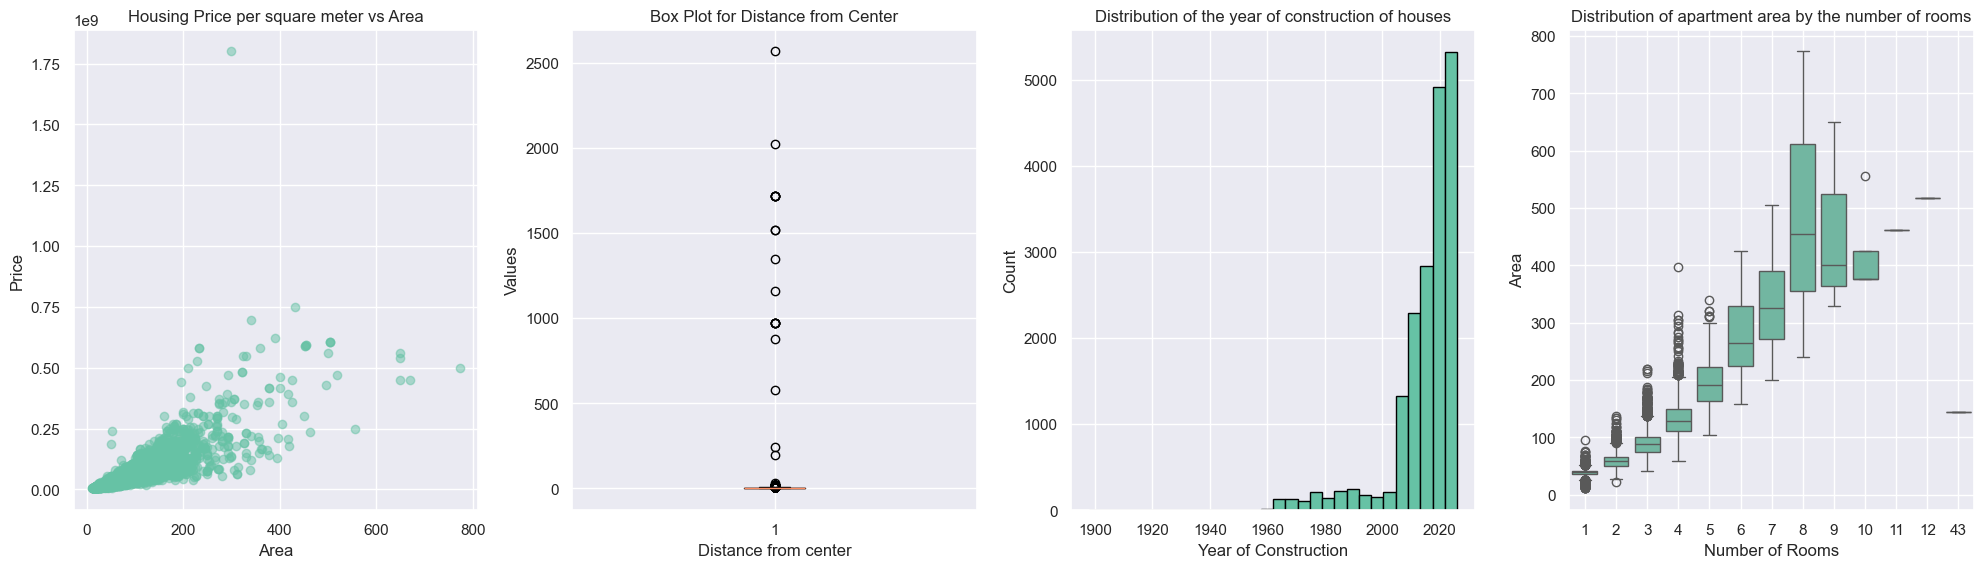

In [33]:
display(df.describe())
object_columns = df.select_dtypes(include=['object'])
display(object_columns.describe())


plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)  
plt.scatter(df['area'], df['price'], alpha=0.5)
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Housing Price per square meter vs Area')
plt.grid(True)

plt.subplot(1, 4, 2)  
plt.boxplot(df['distance_to_center'])
plt.xlabel('Distance from center')
plt.ylabel('Values')
plt.title('Box Plot for Distance from Center')
plt.grid(True)

plt.subplot(1, 4, 3)  
plt.hist(df['construction_year'], bins=30, edgecolor='black')
plt.title('Distribution of the year of construction of houses')
plt.xlabel('Year of Construction')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 4, 4) 
sns.boxplot(data=df, x='room_count', y='area')
plt.title('Distribution of apartment area by the number of rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Area')
plt.grid(True)

# Displaying all plots
plt.tight_layout() 
plt.show()


In [9]:
def remove_outliers(df):
    # Removing the anomalous single 'apartment' that costs almost 2 billion tenge.
    indices_to_drop = df[(df['price'] >= 1000000000)].index
    df.drop(indices_to_drop, inplace=True)

    # Filter out apartments with an area of less than 28 for old houses, as these are not apartments but rather rooms
    indices_to_drop = df[(df['area'] < 28) & (df.construction_year <= 2000)].index
    df.drop(indices_to_drop, inplace=True)

    # Filter out apartments with an area of less than 15 for all houses, as these are not apartments but rather rooms
    indices_to_drop = df[(df['area'] < 15)].index
    df.drop(indices_to_drop, inplace=True)

    # In the dataset, there are some strange apartments with a price less than 200,000 tenge. It's better to remove them, except for the old houses
    indices_to_drop = df[(df['kzt_sq_m'] <= 200000)&(df['construction_year'] >= 2000)].index
    df.drop(indices_to_drop, inplace=True)

    # Removing data outside Astana
    df = df[(df['distance_to_center'] < 14)].reset_index(drop=True)

    # Filtering 1950s rhinestones at home, there are a couple of apartments there
    df = df[df['construction_year'] > 1950].reset_index(drop=True)
    
    #  cleaning outliers in room_count
    df = df[df['room_count'] <= 15].reset_index(drop=True)

    return  df

In [35]:
before = df.shape[0]

# Usage:
df = remove_outliers(df)

after = df.shape[0]
print("Number of outliers-apartments, filtering them:", before-after)

Number of outliers-apartments, filtering them: 187


<blockquote style="font-size: 20px; color: green;">
The addresses that are outside of Astana are removed at this stage, most often because people with errors entered their addresses, but there are few of them.
</blockquote>

### Determining the target feature

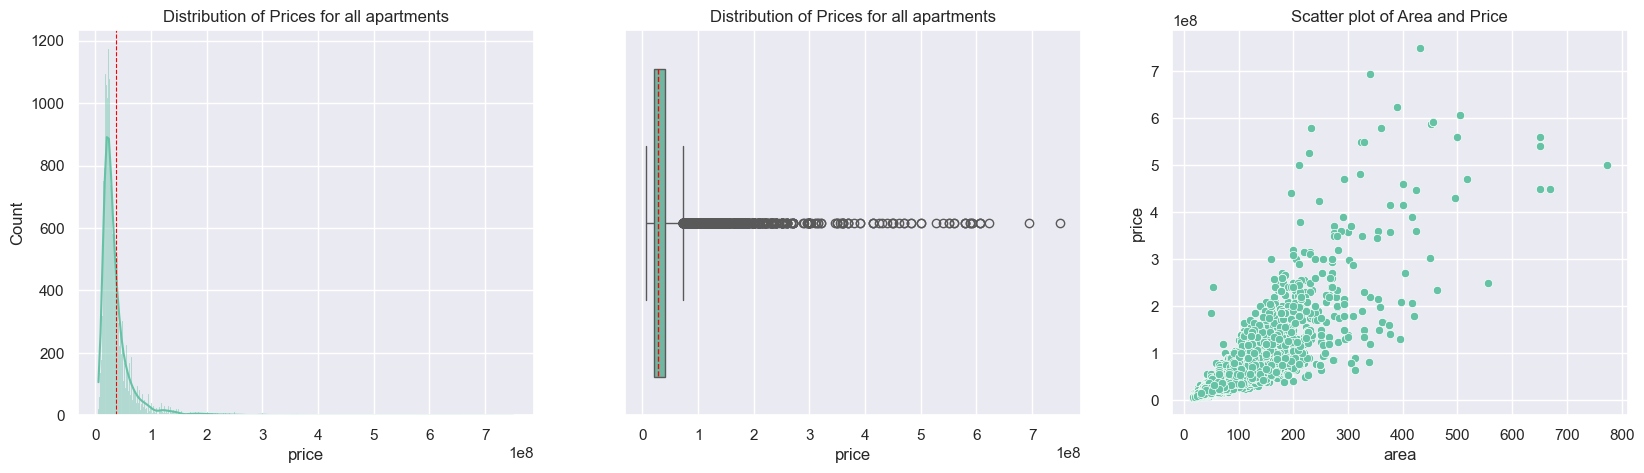

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5)) 

sns.histplot(df['price'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Prices for all apartments')
axes[0].axvline(df['price'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['price'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_title('Distribution of Prices for all apartments')

sns.scatterplot(x='area', y='price', data=df, ax=axes[2])
axes[2].set_title('Scatter plot of Area and Price')

plt.show()

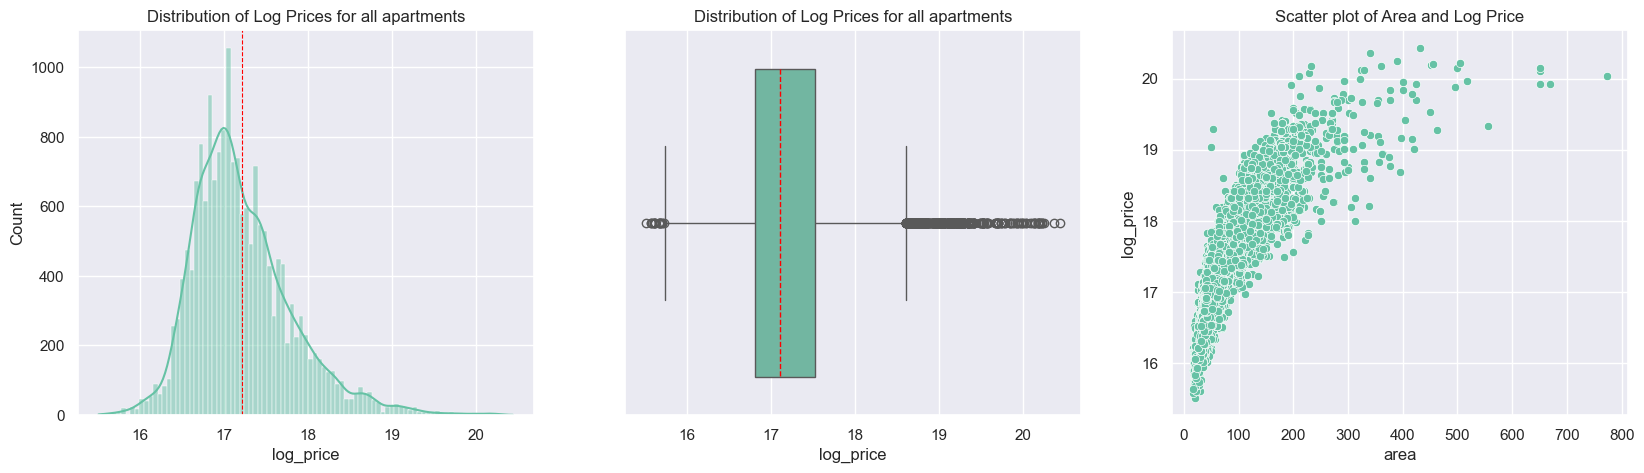

In [37]:
# Applying a logarithmic transformation to the price data
df['log_price'] = np.log(df['price'])

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(df['log_price'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Log Prices for all apartments')
axes[0].axvline(df['log_price'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['log_price'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_title('Distribution of Log Prices for all apartments')

sns.scatterplot(x='area', y='log_price', data=df, ax=axes[2])
axes[2].set_title('Scatter plot of Area and Log Price')

plt.show()

<blockquote style="font-size: 20px; color: green;">
Since the distribution of the target feature is far from normal, it was decided to use logarithm transformation.
</blockquote>

In [26]:
# Perform the D'Agostino and Pearson's omnibus normality test
_, p = stats.normaltest(df['log_price'])

decision_normality(p, alpha = 0.05)

p-value = 0.000
p-value is less than the specified significance level 0.05. The distribution differs from normal.


### Ceiling height of apartaments

In [10]:
def process_ceiling_height(x):
    if not pd.isnull(x):
        return min([2.5, 2.7, 2.8, 2.9, 3, 3.3, 3.5, 4], key=lambda y: abs(x - y))
    else:
        return np.nan

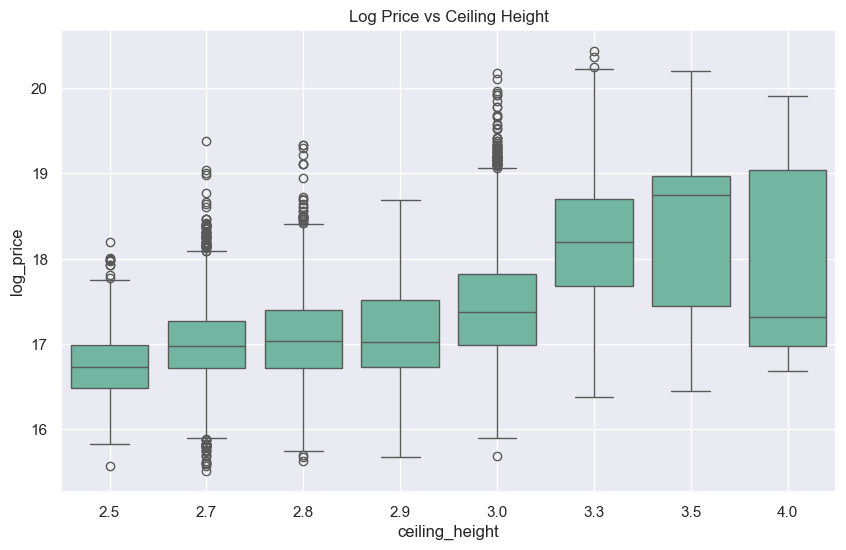

In [38]:
df.loc[:, 'ceiling_height'] = df['ceiling_height'].apply(process_ceiling_height)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ceiling_height', y='log_price')
plt.title('Log Price vs Ceiling Height')
plt.grid(True)
plt.show()

<blockquote style="font-size: 20px; color: green;">
I decided to round the ceiling height because there is very little data for some of them, and 2 seems to be an incorrect user input
</blockquote>

In [11]:
def adjust_ceiling_height(df):    
    '''
    Adjusts ceiling heights in the DataFrame based on certain conditions.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    DataFrame: The DataFrame with adjusted ceiling heights.
    '''
    index_to_change = df[(df['complex_name']=='отрада')].index
    df.loc[index_to_change, 'complex_class'] = "comfort"
    index_to_change = df[(df['ceiling_height']==3.5)&(df['complex_class']=='economy')].index
    df.loc[index_to_change, 'ceiling_height'] = 2.7
    index_to_change = df[(df['ceiling_height']==3.5)&(df['complex_class']=='comfort')].index
    df.loc[index_to_change, 'ceiling_height'] = 2.8
    index_to_change = df[(df['ceiling_height']==4.0)&(df['complex_class']=='economy')].index
    df.loc[index_to_change, 'ceiling_height'] = 2.7
    index_to_change = df[(df['ceiling_height']==4.0)&(df['complex_class']=='comfort')].index
    df.loc[index_to_change, 'ceiling_height'] = 2.8
    index_to_change = df[(df['ceiling_height']==2.5)&(df['complex_class']=='business')&(df['last_floor']==False)].index
    df.loc[index_to_change, 'ceiling_height'] = 3.0
    index_to_change = df[(df['ceiling_height']==2.7)&(df['complex_class']=='premium')&(df['last_floor']==False)].index
    df.loc[index_to_change, 'ceiling_height'] = 3.0
    index_to_change = df[(df['ceiling_height']==2.7)&(df['complex_class']=='business')&(df['last_floor']==False)].index
    df.loc[index_to_change, 'ceiling_height'] = 3.0
    index_to_change = df[(df['ceiling_height']==2.8)&(df['complex_class']=='premium')&(df['last_floor']==False)].index
    df.loc[index_to_change, 'ceiling_height'] = 3.0
    index_to_change = df[(df['ceiling_height']==3.0)&(df['complex_class']=='economy')&(df['construction_year']>=1980)].index
    df.loc[index_to_change, 'ceiling_height'] = 2.7
    index_to_change = df[(df['ceiling_height']==3.3)&(df['complex_class']=='economy')&(df['construction_year']>=1980)].index
    df.loc[index_to_change, 'ceiling_height'] = 2.7
    return df

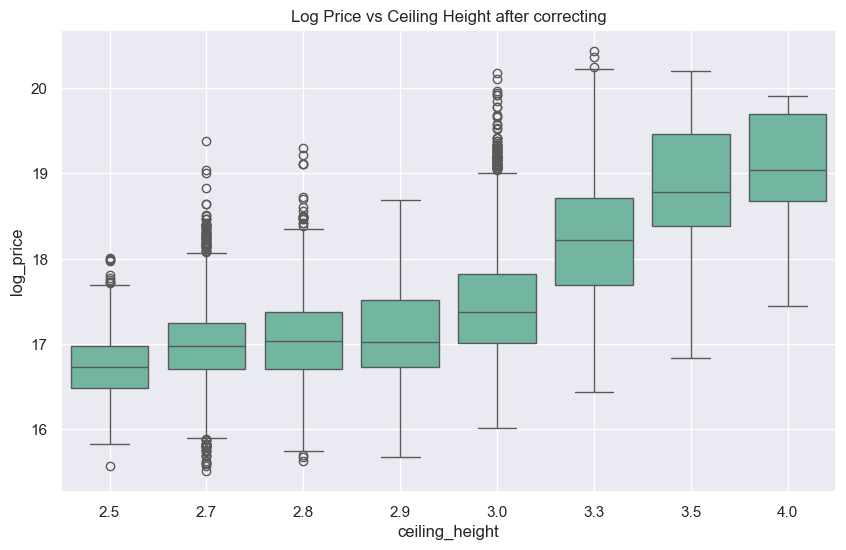

In [40]:
# Usage:
df = adjust_ceiling_height(df)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ceiling_height', y='log_price')
plt.title('Log Price vs Ceiling Height after correcting')
plt.grid(True)
plt.show()

<blockquote style="font-size: 20px; color: green;">
After visualization, it was found that there were errors in the complex class, which have been corrected.
</blockquote>

### Features regarding to distance from points 

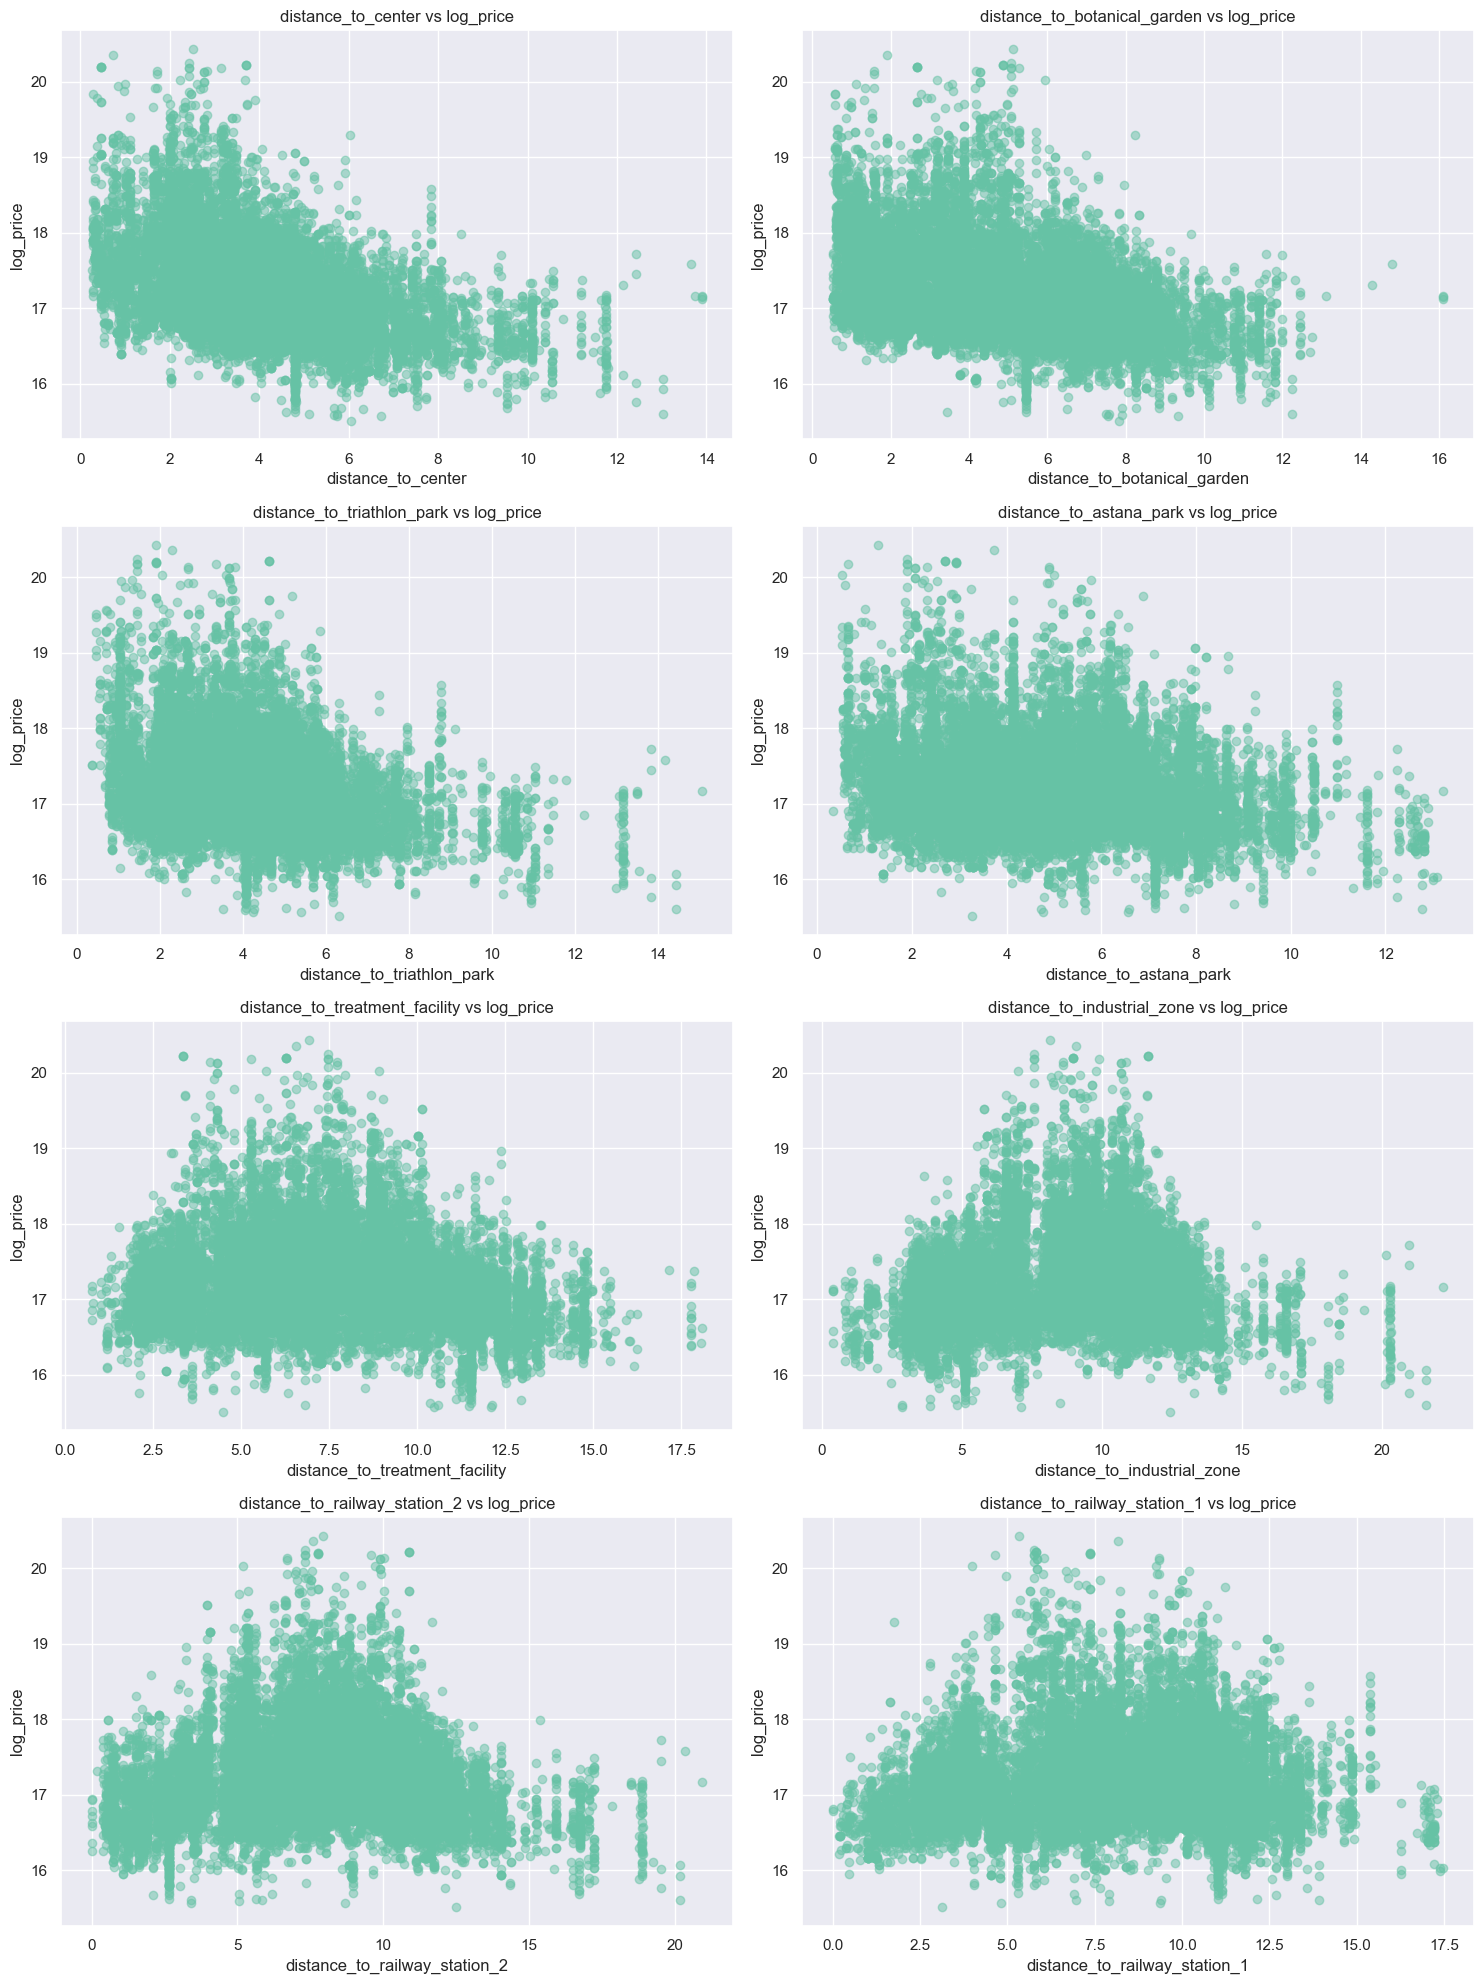

In [73]:
features =[
    'distance_to_center' , 'distance_to_botanical_garden', 
    'distance_to_triathlon_park', 'distance_to_astana_park', 
    'distance_to_treatment_facility', 'distance_to_industrial_zone',
    'distance_to_railway_station_2', 'distance_to_railway_station_1',
]

target_feature = 'log_price'

num_rows = (len(features) + 1) // 2 
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.scatter(df[feature], df[target_feature], alpha=0.5)
    ax.set_title(f'{feature} vs {target_feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel(target_feature)
    
plt.tight_layout()

<blockquote style="font-size: 20px; color: green;">

From the graphs, it can be seen that the features: 'distance_to_center', 'distance_to_botanical_garden', 'distance_to_triathlon_park', and 'distance_to_astana_park' exhibit a slight decreasing dependency on the target feature. The farther the distance from the point, the lower the price.            
 
The rest of the features: 'distance_to_treatment_facility', 'distance_to_industrial_zone', 'distance_to_railway_station_2', 'distance_to_railway_station_1', also show a slight dependency; up to 10 km, there is a trend where the farther the point, the more expensive it is, which makes logical sense.   
 
Whether to delete these features or not will be determined during the training stage.
</blockquote>

### Complex class

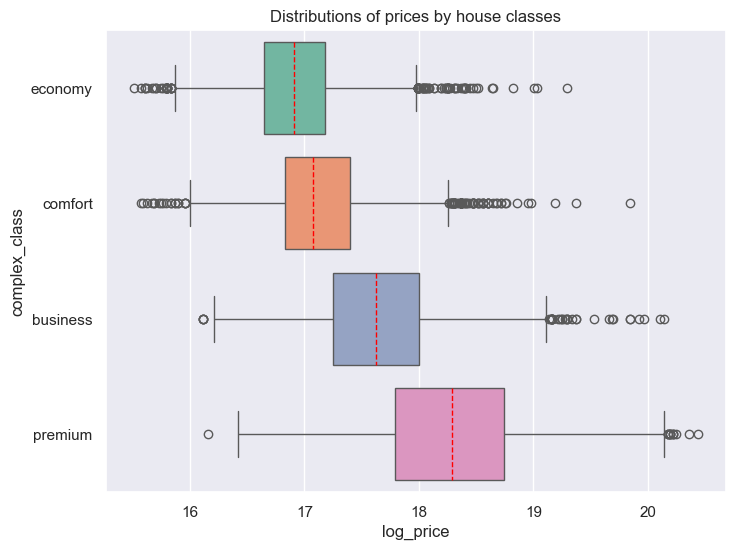

In [48]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(df, x='log_price', y='complex_class', orient='h', hue='complex_class', medianprops={"color": "red", "linestyle": '--'})
plt.title('Distributions of prices by house classes')
plt.show()

<blockquote style="font-size: 20px; color: green;">
As expected, the price increases depending on the class. We will keep this feature.
</blockquote>

### Statistical measures for categorical features

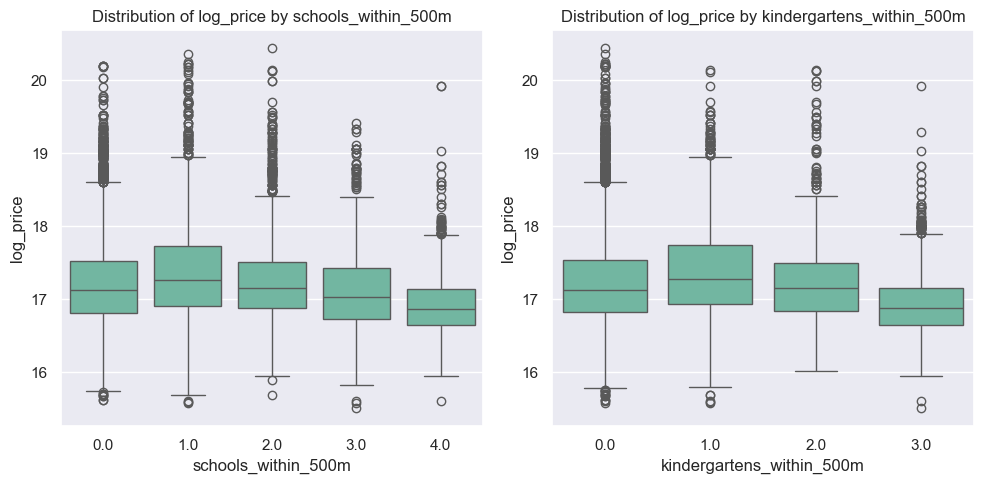

In [49]:
df['schools_within_500m'] = df['schools_within_500m'].apply(lambda x: min(x, 4))
df['kindergartens_within_500m'] = df['kindergartens_within_500m'].apply(lambda x: min(x, 3))

features =['schools_within_500m', 'kindergartens_within_500m']
target_feature = 'log_price'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, feature in enumerate(features):
    sns.boxplot(x=feature, y=target_feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {target_feature} by {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_feature)

plt.tight_layout()
plt.show()

Does the region affect the number of schools within a 500-meter radius on the price?

Null Hypothesis ($H_0$):  The apartment price does not differ based on the number of schools in the neighborhood.  
Alternative Hypothesis ($H_1$): The apartment price differs based on the number of schools in the neighborhood.  

In [11]:
prices_by_school_count = [df.loc[df['schools_within_500m']==i, 'log_price'] for i in range(5)]

_, p = stats.kruskal(*prices_by_school_count)

decision_hypothesis(p)

p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.


Does the region affect the number of kindergartens within a 500-meter radius on the price?

Null Hypothesis ($H_0$):  The apartment price does not differ based on the number of kindergartens in the neighborhood.  
Alternative Hypothesis ($H_1$): The apartment price differs based on the number of kindergartens in the neighborhood.


In [21]:
prices_by_kindergarten_count = [df.loc[df['kindergartens_within_500m']==i, 'log_price'] for i in range(4)]

_, p = stats.kruskal(*prices_by_kindergarten_count)

decision_hypothesis(p)

p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.


Does the presence of a park in radius 1 km affect the price?

Null Hypothesis ($H_0$):  The apartment price does not differ based on the presence of a park in radius 1 km.  
Alternative Hypothesis ($H_1$): The apartment price differs based on the presence of a park in radius 1 km.

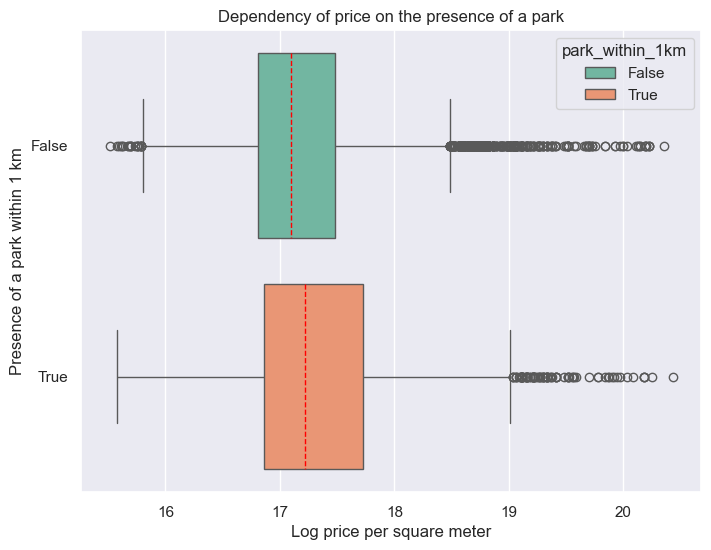

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(df, x='log_price', y='park_within_1km', orient='h', hue='park_within_1km',  medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Log price per square meter', ylabel='Presence of a park within 1 km')
plt.title('Dependency of price on the presence of a park')
plt.show()

In [43]:
park_true = df.loc[df['park_within_1km']==True, 'log_price']
park_false = df.loc[df['park_within_1km']==False, 'log_price']

_, p = stats.mannwhitneyu(
    park_true, park_false
)   
decision_hypothesis(p)

p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.


Is there a statistically significant difference in the log prices of apartments based on whether they are pledged or not?

Null Hypothesis ($H_0$): The log prices of apartments are not different between pledged and non-pledged apartments.  
Alternative Hypothesis ($H_1$): The log prices of apartments are different between pledged and non-pledged apartments.

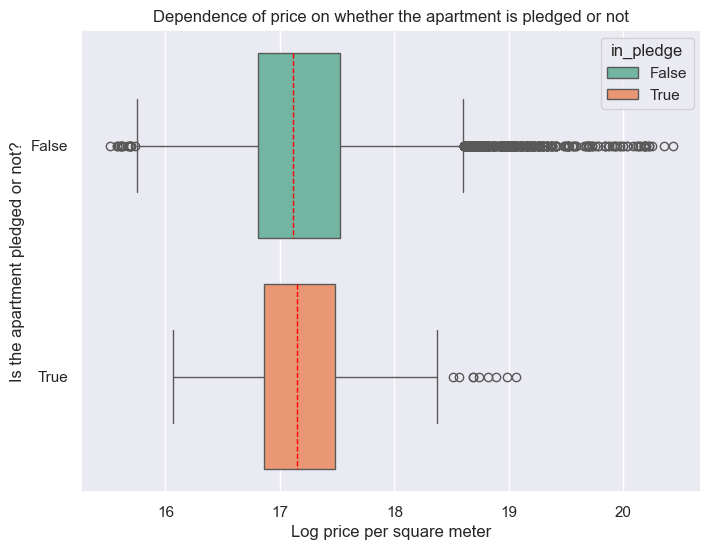

In [50]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(df, x='log_price', y='in_pledge', orient='h', hue='in_pledge',  medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Log price per square meter', ylabel='Is the apartment pledged or not?')
plt.title("Dependence of price on whether the apartment is pledged or not")
plt.show()

In [44]:
in_pledge_true = df.loc[df['in_pledge']==True, 'log_price']
in_pledge_false = df.loc[df['in_pledge']==False, 'log_price']

_, p = stats.mannwhitneyu(
    in_pledge_true, in_pledge_false
)   
decision_hypothesis(p)

p-value = 0.460
p-value is greater than the specified significance level 0.05. No statistically significant differences between categories.


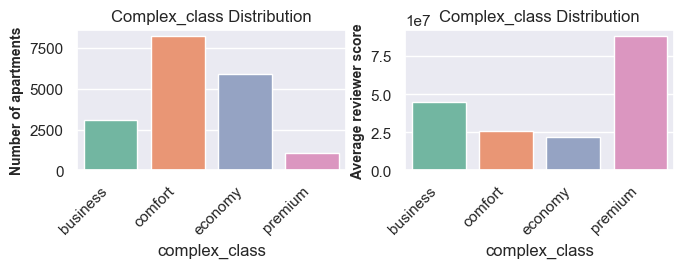

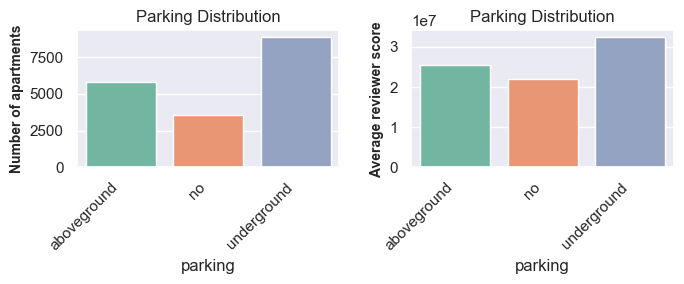

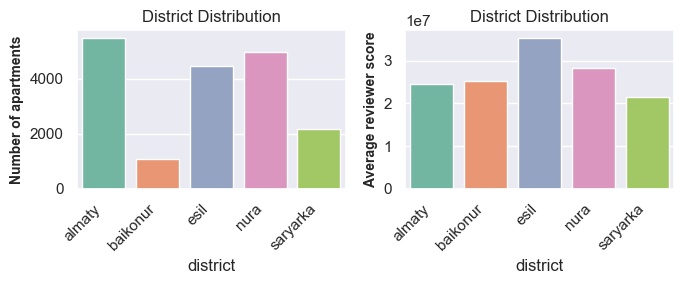

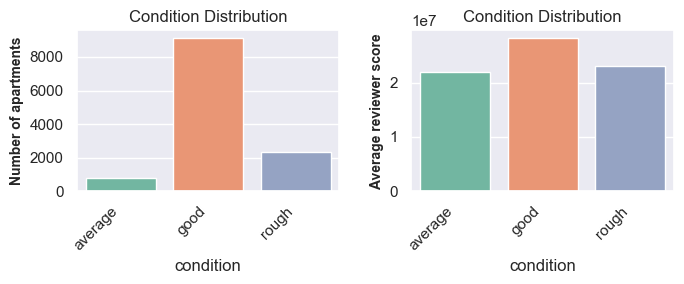

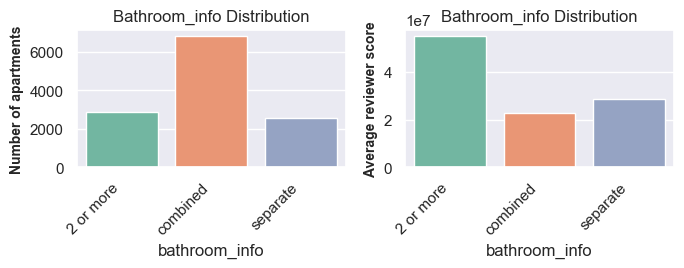

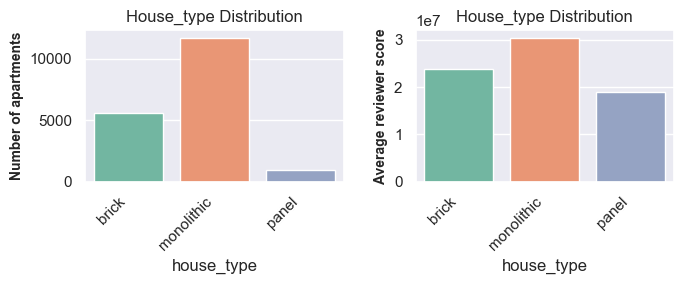

In [51]:
cat_features = ['complex_class', 'parking', 'district', 'condition', 'bathroom_info', 'house_type']

# Suppress warnings
warnings.filterwarnings("ignore")

for feature in cat_features:
    pivot = pd.pivot_table(
        data=df,
        index=feature, 
        values='price', 
        aggfunc=['count', 'median'])

    fig, ax = plt.subplots(1, 2, figsize=(7, 3))

    sns.barplot(x=pivot.index, y=pivot[('count', 'price')], ax=ax[0], hue=pivot.index, legend=False) 
    ax[0].set_ylabel('Number of apartments', fontweight='bold', fontsize=10)
    ax[0].set_xticks(range(len(pivot.index)))  # Setting the ticks
    ax[0].set_xticklabels(pivot.index, rotation=45, ha='right')  # Setting the labels
    ax[0].set_title(f'{feature.capitalize()} Distribution')

    sns.barplot(x=pivot.index, y=pivot[('median', 'price')], ax=ax[1], hue=pivot.index, legend=False) 
    ax[1].set_ylabel('Average reviewer score', fontweight='bold', fontsize=10)
    ax[1].set_xticks(range(len(pivot.index)))  # Setting the ticks
    ax[1].set_xticklabels(pivot.index, rotation=45, ha='right')  # Setting the labels
    ax[1].set_title(f'{feature.capitalize()} Distribution')

    plt.tight_layout()

plt.show()

In [39]:
df_cleaned = df.dropna(subset=cat_features + ['log_price'])
categories_data = []
for feature in cat_features:
    categories_data.append([df_cleaned[df_cleaned[feature] == category]['log_price'] for category in df_cleaned[feature].unique()])

for i, feature_data in enumerate(categories_data):
    statistic, p_value = stats.kruskal(*feature_data)
    print(f"Feature: {cat_features[i]}")
    decision_hypothesis(p_value, alpha = 0.05 )

Feature: complex_class
p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.
Feature: parking
p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.
Feature: district
p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.
Feature: condition
p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.
Feature: bathroom_info
p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.
Feature: house_type
p-value = 0.000
p-value is less than the specified significance level 0.05. Differences between categories are statistically significant.


<blockquote style="font-size: 20px; color: green;">

Statistical tests were chosen differently depending on the number of categories, but all of them were non-parametric because it was found early on that even the logarithm-transformed feature does not have a normal distribution. 

All conducted tests showed that all categories have statistical significance, except for the pledged feature, although it seems visually that they are not important. Therefore, the decision to remove or keep them was postponed until the training phase.
</blockquote>

In [15]:
# Saving cleaned data to a file to prevent data 
save_data(df, "df")

## Encoding and data preparation for training

[[ go back to the top ]](#Table-of-contents)   


In [2]:
data = read_data('df')
# Drop irrelevant columns
irrelevant_columns = ['name', 'information', 'address', 'price', 'coordinates', 'kzt_sq_m', 'condition', 'bathroom_info']
data.drop(irrelevant_columns , axis=1, inplace=True)

# Label encoding for the 'elevator' column
label_encoder = LabelEncoder()
data['elevator'] = label_encoder.fit_transform(data['elevator'])

# Ordinal encoding for the 'complex_class' column
complex_class_order = ['economy', 'comfort', 'business', 'premium']  
complex_class_ordinal_encoder = OrdinalEncoder(categories=[complex_class_order])
data['complex_class'] = complex_class_ordinal_encoder.fit_transform(data[['complex_class']])

# Replace values of complex_name that occur less than 35 times with 'others'
category_counts = data['complex_name'].value_counts()
categories_to_replace = category_counts[category_counts < 35].index
data.loc[data['complex_name'].isin(categories_to_replace), 'complex_name'] = 'others'

# Binary encoding for the 'complex_name' column
encoder = BinaryEncoder(cols=['complex_name'])
data_encoded = encoder.fit_transform(data['complex_name'])
data = pd.concat([data, data_encoded], axis=1)
data.drop(['complex_name'], axis=1, inplace=True)

# One-hot encoding for nominal categorical features
nominal_categorical_features = ['parking', 'district', 'house_type', 'ceiling_height', 'owner']
data = pd.get_dummies(data, columns=nominal_categorical_features)


# Splitting the data into training and testing sets

X = data.drop(columns=['log_price'])
y = data['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (14597, 49)
Test shape: (3650, 49)


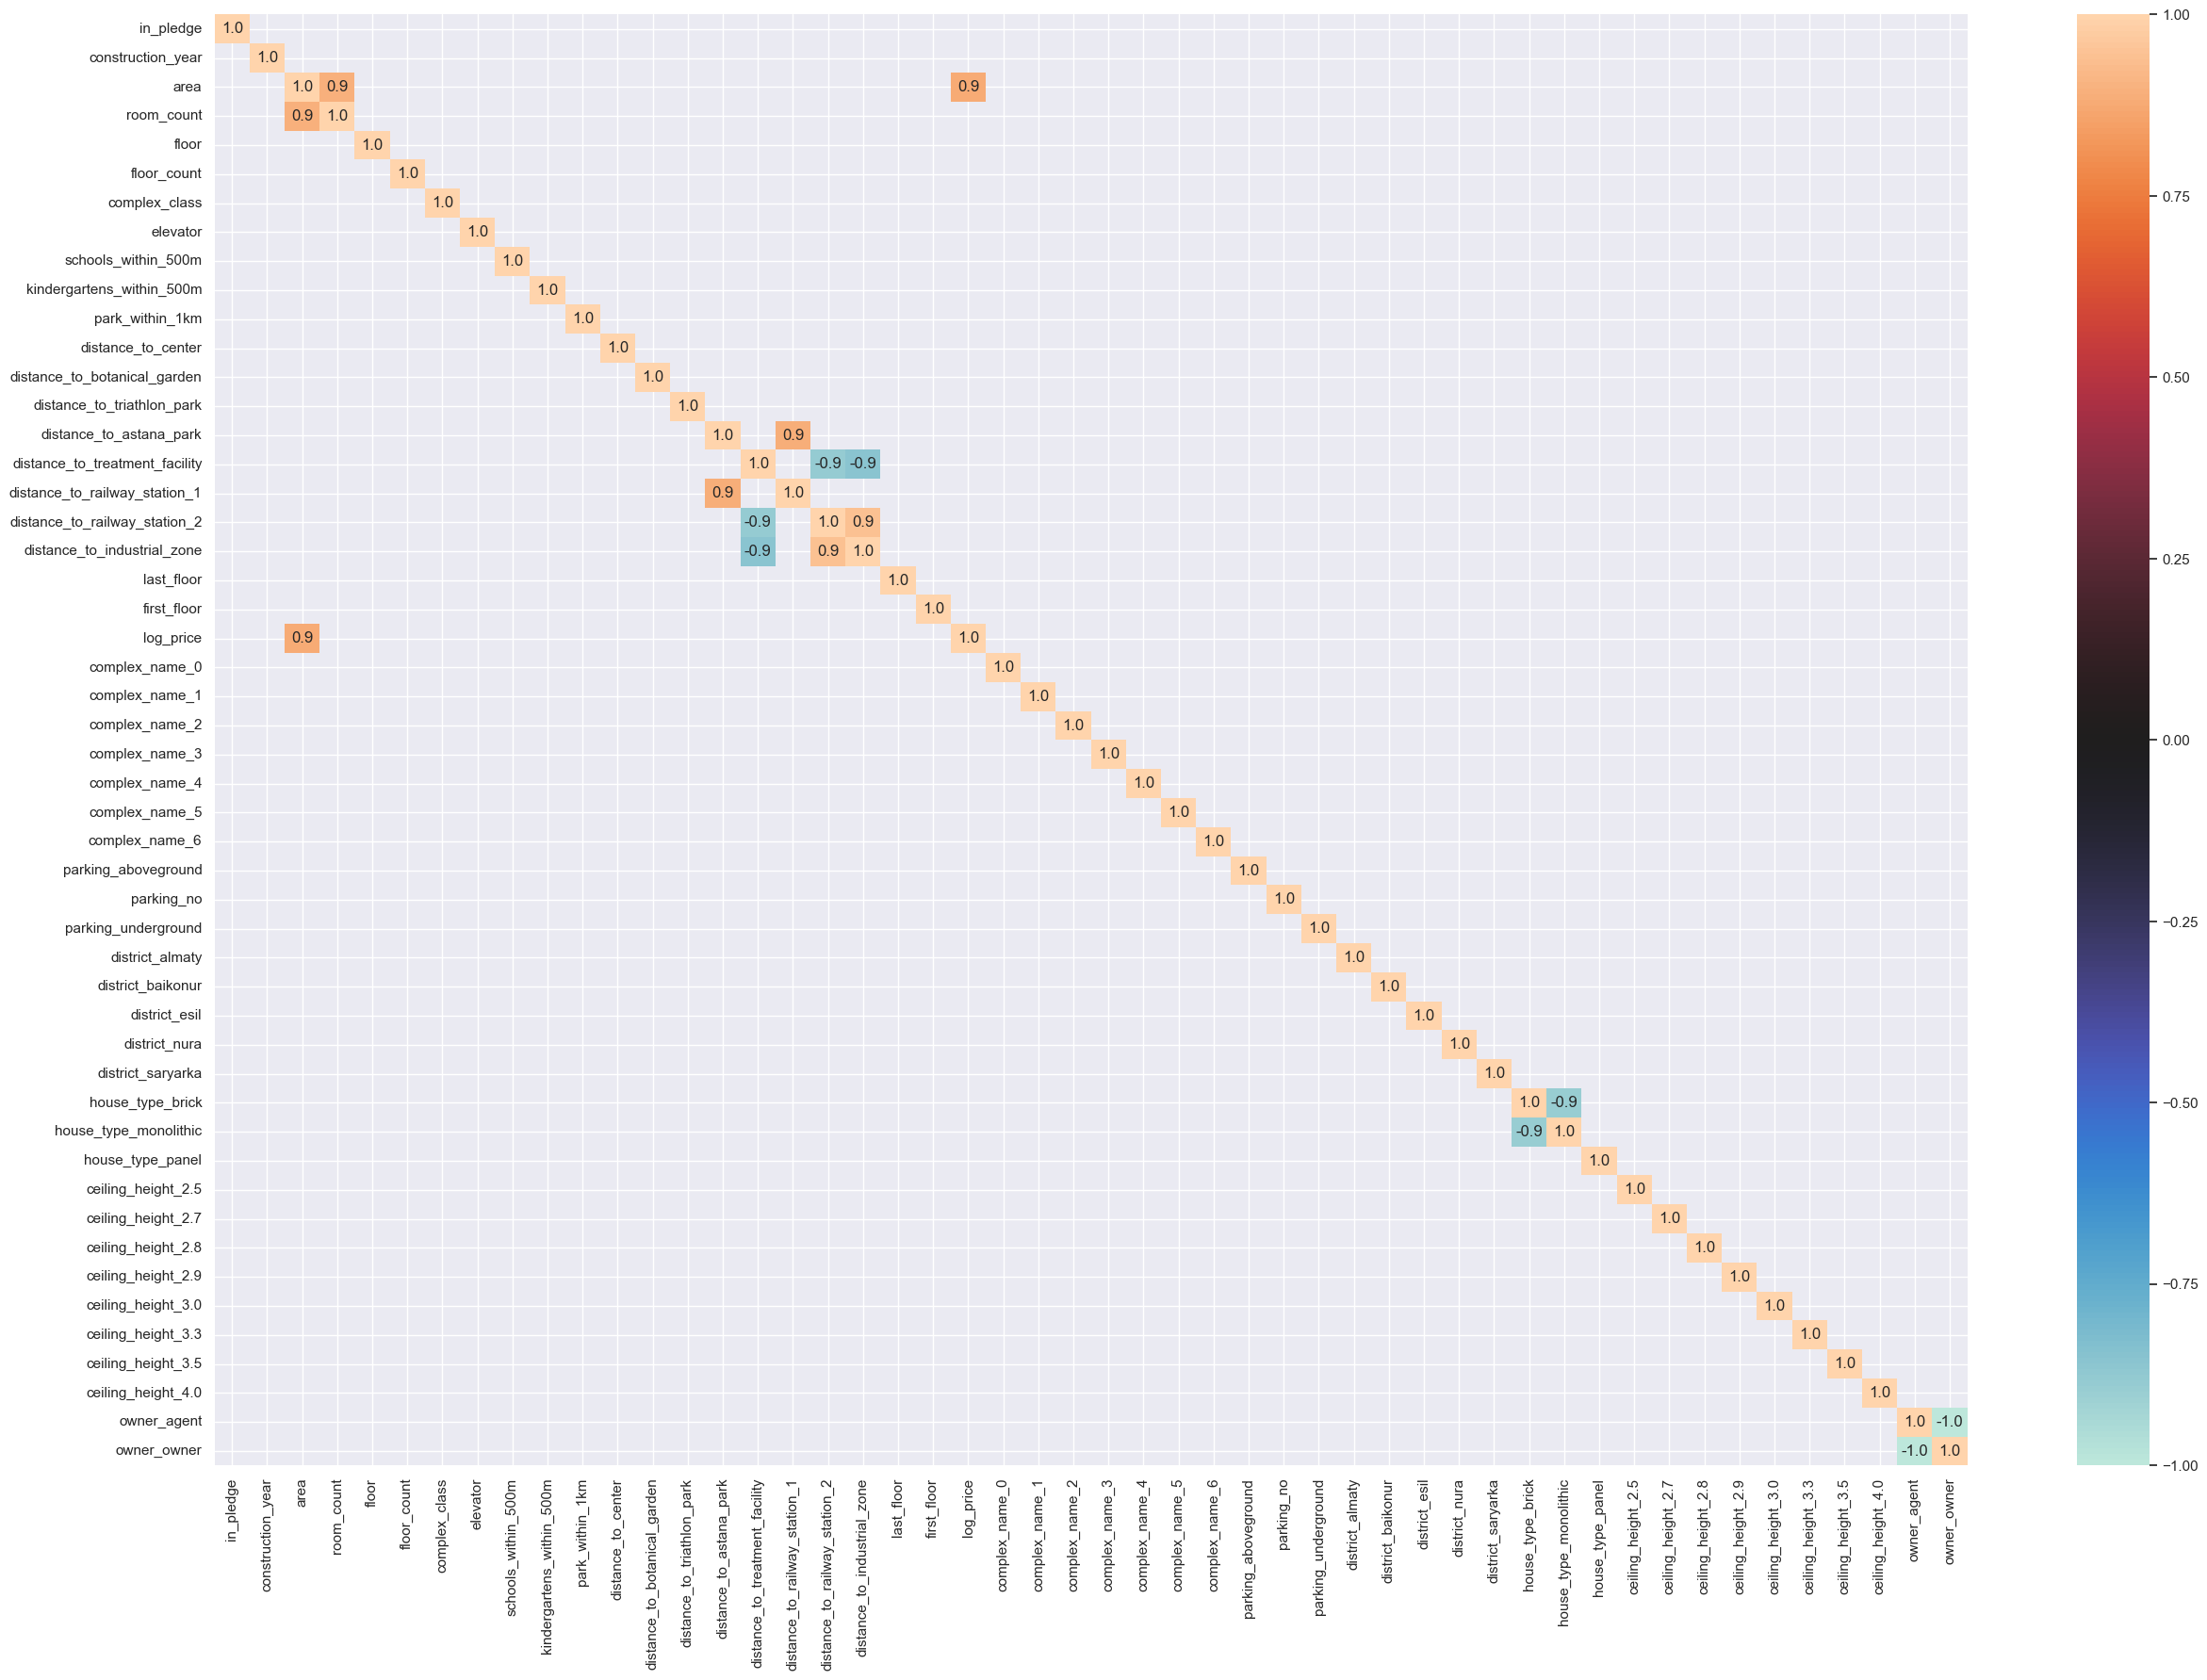

In [14]:
corr = data.corr(method='spearman')

plt.rcParams['figure.figsize'] = (30, 20)
heatmap_corr = sns.heatmap(corr[corr.abs() > 0.8], annot=True, vmin=-1, vmax=1, center=0, fmt='.1f')

plt.show()

<blockquote style="font-size: 20px; color: green;">

The only feature that shows a strong correlation with the target variable is the apartment area, and we will definitely not delete this feature. However, other features that exhibit strong dependency among themselves will be removed if it becomes evident during training that they have little significance.
</blockquote>

##  Feature and Model Selection

[[ go back to the top ]](#Table-of-contents)   


### Base Models 

In [3]:
base_models = {
    "Ridge": make_pipeline(StandardScaler(), Ridge(random_state=SEED)),
    "SVR": make_pipeline(StandardScaler(), SVR()),
    "Random Forest": RandomForestRegressor(random_state=SEED),
    "Gradient Boosting": GradientBoostingRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED),
    "CatBoost": CatBoostRegressor(random_state=SEED, silent=True)
}

mre_scorer = make_scorer(mean_relative_error, greater_is_better=False)

for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mre_train = mean_relative_error(y_train, y_train_pred)
    y_test_pred = model.predict(X_test)
    mre_test = mean_relative_error(y_test, y_test_pred)
    print(f"Model: {name}")
    print(f"Train MRE: {round(mre_train, 3)}")
    print(f"Test MRE: {round(mre_test, 3)}")
    experiment.log_metric(f"{name} Train MRE", round(mre_train, 3))
    experiment.log_metric(f"{name} Test MRE", round(mre_test, 3))
    experiment.log_parameters({"features": X_train.columns.tolist()})

Model: Ridge
Train MRE: 0.167
Test MRE: 0.177


Model: SVR
Train MRE: 0.104
Test MRE: 0.125
Model: Random Forest
Train MRE: 0.039
Test MRE: 0.105
Model: Gradient Boosting
Train MRE: 0.123
Test MRE: 0.13
Model: XGBoost
Train MRE: 0.076
Test MRE: 0.107
Model: CatBoost
Train MRE: 0.09
Test MRE: 0.107


<blockquote style="font-size: 20px; color: green;">

To have a comprehensive understanding, training was conducted on baseline models to observe changes in metrics after hyperparameter tuning and feature selection.

The metric MRE was chosen because it has:

- Interpretability: Mean Relative Error (MRE) is easy to interpret as it measures relative error.

- Scale-invariance: MRE is not affected by the scale of the target variable, allowing for model comparison across different datasets.
</blockquote>

### Parameter tuning

In [41]:
%%time

models = {
    "Ridge": make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge(random_state=SEED)),
    "Random Forest": RandomForestRegressor(random_state=SEED),
    "Gradient Boosting": GradientBoostingRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED)
}

param_spaces = {
    "Ridge": {
        'ridge__alpha': hp.loguniform('ridge__alpha', np.log(0.1), np.log(10))
    },
    "Random Forest": {
        'n_estimators': hp.randint('n_estimators', 50, 101), 
        'max_depth': hp.randint('max_depth', 1, 11),  # 21, 
        'min_samples_split': hp.randint('min_samples_split', 2, 15), 
        'min_samples_leaf': hp.randint('min_samples_leaf', 2, 15),
    },
    "Gradient Boosting": {
        'n_estimators': hp.randint('n_estimators', 50, 101),  
        'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),  
        'max_depth': hp.randint('max_depth', 1, 11),  
        'min_samples_split': hp.randint('min_samples_split', 2, 15),  
        'min_samples_leaf': hp.randint('min_samples_leaf', 2, 15), 
        'subsample': hp.uniform('subsample', 0.5, 1.0), 
        'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2', None]) 
    },
    "XGBoost": {
        'n_estimators': hp.randint('n_estimators', 50, 201),  
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),  
        'max_depth': hp.randint('max_depth', 1, 21), 
        'min_child_weight': hp.randint('min_child_weight', 1, 51),  
        'gamma': hp.loguniform('gamma', np.log(0.1), np.log(10)),  
        'eta': hp.uniform('eta', 0.01, 0.3),  
        'reg_alpha': hp.uniform('reg_alpha', 0.1, 2.0), 
        'reg_lambda': hp.uniform('reg_lambda', 0.1, 2.0),  
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)  
    }
}

best_parameters = {}
mre_scorer = make_scorer(mean_relative_error, greater_is_better=False)

for name, model in models.items():

    space = param_spaces.get(name, {})
    trials = Trials()
    
    def objective(params, cv=5, X=X_train, y=y_train, random_state=SEED):
        model.set_params(**params)
        scores = cross_val_score(model, X, y, cv=cv, scoring=mre_scorer)
        score = np.sqrt(-scores.mean())
        return score
    
    best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
    best_parameters[name] = best
    
    print(f"Model: {name}")
    print("Best parameters:", best)

100%|██████████| 50/50 [08:38<00:00, 10.37s/trial, best loss: 0.36252186166146433]
Model: Ridge
Best parameters: {'ridge__alpha': 9.99020948113406}
100%|██████████| 50/50 [26:12<00:00, 31.45s/trial, best loss: 0.3486853410491106]
Model: Random Forest
Best parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 86}
100%|██████████| 50/50 [22:35<00:00, 27.12s/trial, best loss: 0.3230428383310889]
Model: Gradient Boosting
Best parameters: {'learning_rate': 0.1054078562478077, 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 92, 'subsample': 0.7723963549384848}
100%|██████████| 50/50 [02:50<00:00,  3.40s/trial, best loss: 0.3429676342875009] 
Model: XGBoost
Best parameters: {'eta': 0.17570954678263595, 'gamma': 0.12304170016907395, 'learning_rate': 0.07704036261083533, 'max_depth': 6, 'min_child_weight': 24, 'n_estimators': 136, 'reg_alpha': 0.1236736222656375, 'reg_lambda': 1.6182694682202823, 'scale_pos

<blockquote style="font-size: 20px; color: green;">

During the hyperparameter tuning process, SVR was excluded due to its requirement for significant computational resources. CatBoost was excluded for the same reason, but it also has the best performance metrics and no overfitting.
</blockquote> 

### Setting best parameters 

In [5]:
for name, model in models.items():
    if name == "Ridge":
        model.set_params(**best_parameters["Ridge"])
    elif name == "Random Forest":
        model.set_params(**best_parameters["Random Forest"])
    elif name == "Gradient Boosting":
        model.set_params(**best_parameters["Gradient Boosting"])
    elif name == "XGBoost":
        model.set_params(**best_parameters["XGBoost"])
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mre_train = mean_relative_error(y_train, y_train_pred)
    y_test_pred = model.predict(X_test)
    mre_test = mean_relative_error(y_test, y_test_pred)
    print(f"Model: {name}")
    print(f"Train MRE: {round(mre_train, 3)}")
    print(f"Test MRE: {round(mre_test, 3)}")
    
    # Logging parameters and metrics
    experiment.log_metric(f"⬆️ {name} Train MRE", round(mre_train, 3))
    experiment.log_metric(f"⬆️ {name} Test MRE", round(mre_test, 3))
    experiment.log_parameter(f"Best Parameters of {name}", best_parameters[name])
    experiment.log_parameters({"features": X_train.columns.tolist()})

Model: Ridge
Train MRE: 0.119
Test MRE: 0.129
Model: Random Forest
Train MRE: 0.099
Test MRE: 0.123
Model: Gradient Boosting
Train MRE: 0.085
Test MRE: 0.115
Model: XGBoost
Train MRE: 0.105
Test MRE: 0.118


<blockquote style="font-size: 20px; color: green;">

While significant improvement was observed after hyperparameter tuning in both the Gradient Boosting and XGBoost models, it led to increased overfitting in the Gradient Boosting model. Despite numerous attempts at hyperparameter tuning using various methods, improving the metric without exacerbating overfitting proved challenging. However, with XGBoost, overfitting was successfully reduced, albeit at the cost of a slight deterioration in the metric.
</blockquote>

### Feature Selection

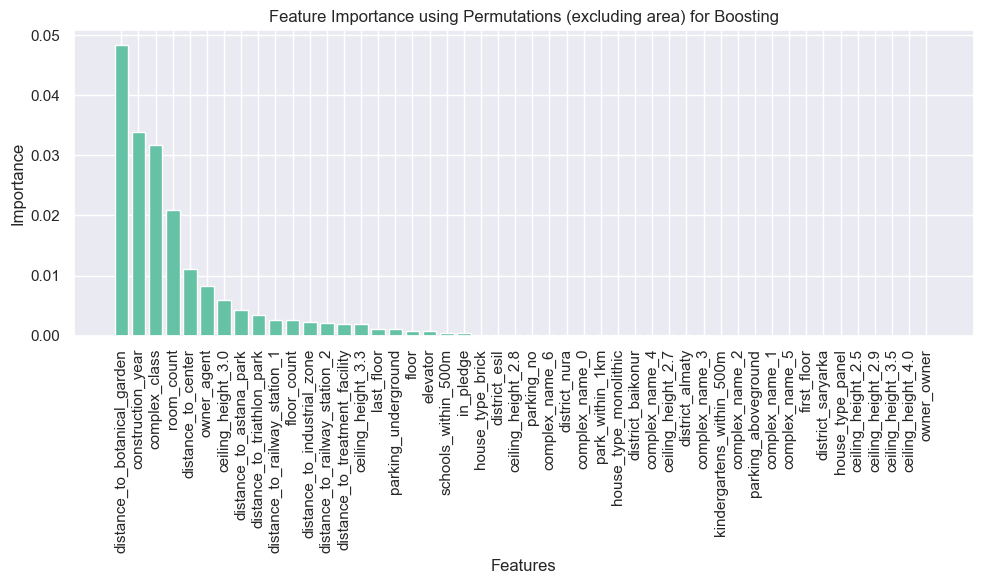

In [57]:
xgb_model = XGBRegressor(random_state=SEED, **best_parameters["XGBoost"])
xgb_model.fit(X_train, y_train)

# Evaluating feature importance using permutations
result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=SEED)

# Getting the mean importance of features
importance = result.importances_mean

# Getting the feature names
feature_names = X_test.columns

# Getting the indices of features in descending order of their importance
sorted_indices_xgb = importance.argsort()[::-1]

# Excluding the first feature by importance
excluded_feature_index = sorted_indices_xgb[0]
sorted_indices_without_first = np.delete(sorted_indices_xgb, 0)  # Delete the first index which corresponds to the most important feature
excluded_feature_name = feature_names[excluded_feature_index]

# Displaying features by importance as a plot without the first feature
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)-1), importance[sorted_indices_without_first], tick_label=feature_names[sorted_indices_without_first])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Permutations (excluding ' + excluded_feature_name + ') for Boosting')
plt.tight_layout()
plt.show()

<blockquote style="font-size: 20px; color: green;">

The feature "area" was removed from visualization as it had a very large value compared to others, which made visualization difficult.
</blockquote>

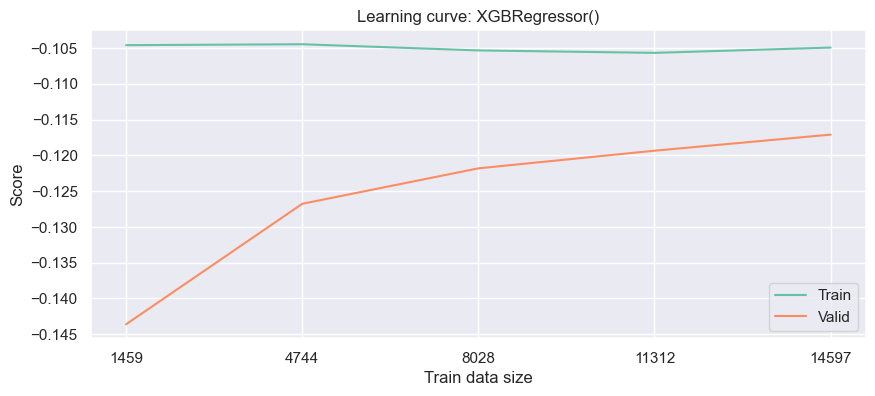

In [45]:
skf = KFold(n_splits=5)
plot_learning_curve(xgb_model, X, y, skf, title=xgb_model.__class__.__name__ + '()')

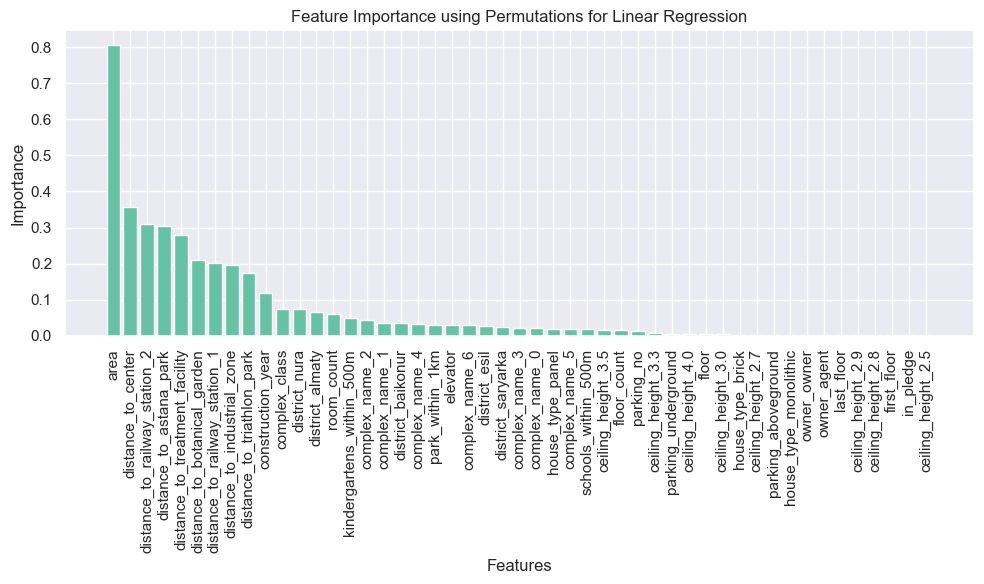

In [58]:
ridge_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Ridge(random_state=SEED))
ridge_model.set_params(**best_parameters["Ridge"])
ridge_model.fit(X_train, y_train)

# Evaluating feature importance using permutations
result = permutation_importance(ridge_model, X_test, y_test, n_repeats=10, random_state=SEED)

# Getting the mean importance of features
importance = result.importances_mean

# Getting the feature names
feature_names = X_test.columns

# Getting the indices of features in descending order of their importance
sorted_indices_ridge = importance.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[sorted_indices_ridge], tick_label=feature_names[sorted_indices_ridge])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance using Permutations for Linear Regression')
plt.tight_layout()
plt.show()

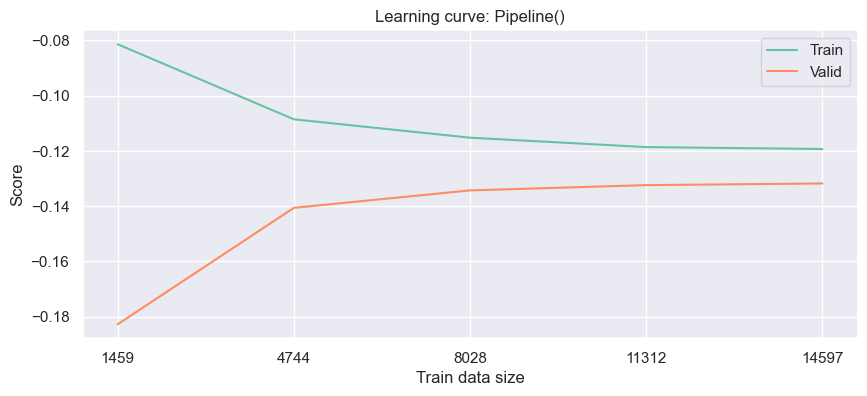

In [47]:
skf = KFold(n_splits=5)
plot_learning_curve(ridge_model, X, y, skf, title=ridge_model.__class__.__name__ + '()')

In [59]:
# Define a set of the last 25 features selected by XGBoost based on their importance
last_25_features_xgb_set = set(feature_names[sorted_indices_xgb][-25:])

# Define a set of the last 25 features selected by Ridge Regression based on their importance
last_25_features_ridge_set = set(feature_names[sorted_indices_ridge][-25:])

# Define a set of the least informative features selected by both XGBoost and Ridge Regression
intersection_features = last_25_features_xgb_set.intersection(last_25_features_ridge_set)

print("Number of the least informative features:", len(intersection_features))
print("The least informative features:", intersection_features)

# Create a copy of the original feature matrix
X_selected = X.copy()

# Drop the least informative features from the feature matrix
X_selected.drop(intersection_features, axis=1, inplace=True)

# Split the dataset into train and test sets with the selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=SEED)

print('Train shape: {}'.format(X_train_selected.shape))
print('Test shape: {}'.format(X_test_selected.shape))

Number of the least informative features: 15
The least informative features: {'parking_aboveground', 'complex_name_0', 'parking_no', 'house_type_monolithic', 'complex_name_3', 'ceiling_height_4.0', 'owner_owner', 'house_type_panel', 'ceiling_height_2.5', 'ceiling_height_2.7', 'ceiling_height_2.8', 'ceiling_height_3.5', 'ceiling_height_2.9', 'first_floor', 'complex_name_5'}
Train shape: (14597, 34)
Test shape: (3650, 34)


<blockquote style="font-size: 20px; color: green;">

To select features based on significance, two different types of models were chosen. This was done to find the least informative features according to both models because in the future, these selected features will be used for training a stacking regressor.
</blockquote>

### Training on selected data with best parameters

In [7]:
for name, model in models.items():
    
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    mre_train = mean_relative_error(y_train, y_train_pred)
    y_test_pred = model.predict(X_test_selected)
    mre_test = mean_relative_error(y_test, y_test_pred)
    print(f"Model: {name}")
    print(f"Train MRE: {round(mre_train, 3)}")
    print(f"Test MRE: {round(mre_test, 3)}")
    
    # Logging parameters and metrics
    experiment.log_metric(f"{name} ✅ Train MRE", round(mre_train, 3))
    experiment.log_metric(f"{name} ✅ Test MRE", round(mre_test, 3))
    experiment.log_parameter(f"Best Parameters of {name}", best_parameters[name])
    experiment.log_parameters({"features": X_train_selected.columns.tolist()})

Model: Ridge
Train MRE: 0.125
Test MRE: 0.133


Model: Random Forest
Train MRE: 0.099
Test MRE: 0.123
Model: Gradient Boosting
Train MRE: 0.078
Test MRE: 0.112
Model: XGBoost
Train MRE: 0.105
Test MRE: 0.119


<blockquote style="font-size: 20px; color: green;">

Feature selection had a positive impact on Linear Regression and Gradient Boosting, improving the metrics for the former and reducing overfitting for the latter. No noticeable changes were observed for other models, so it was decided to retain this feature set.
</blockquote>

### SVR training on selected data 

In [8]:
svr_model = make_pipeline(StandardScaler(), SVR())

svr_model.fit(X_train_selected, y_train)
y_train_pred = svr_model.predict(X_train_selected)

mre_train = mean_relative_error(y_train, y_train_pred)
y_test_pred = svr_model.predict(X_test_selected)
mre_test = mean_relative_error(y_test, y_test_pred)

print(f"Model: SVR")
print(f"Train MRE: {round(mre_train, 3)}")
print(f"Test MRE: {round(mre_test, 3)}")

# Logging parameters and metrics
experiment.log_metric(f"SVR ✅ Train MRE", round(mre_train, 3))
experiment.log_metric(f"SVR ✅ Test MRE", round(mre_test, 3))
experiment.log_parameters(svr_model.get_params())
experiment.log_parameters({"features": X_train_selected.columns.tolist()})

Model: SVR
Train MRE: 0.105
Test MRE: 0.122


<blockquote style="font-size: 20px; color: green;">
After training on the selected data, overfitting decreased slightly, but the metrics did not worsen. This once again confirms that the selection of important features was done correctly.
</blockquote>

### CatBoost training on selected data 

In [9]:
ctb_regressor = CatBoostRegressor(random_state=SEED, silent=True)

ctb_regressor.fit(X_train_selected, y_train)

# Evaluate ctb_regressor quality on the test set
y_train_pred = ctb_regressor.predict(X_train_selected)
mre_train = mean_relative_error(y_train, y_train_pred)
y_test_pred = ctb_regressor.predict(X_test_selected)
mre_test = mean_relative_error(y_test, y_test_pred)

print(f"Train MRE: {round(mre_train, 3)}")
print(f"Test MRE: {round(mre_test, 3)}")
experiment.log_metric(f"CatBoost ✅ Train MRE", round(mre_train, 3))
experiment.log_metric(f"CatBoost ✅ Test MRE", round(mre_test, 3))
experiment.log_parameters(ctb_regressor.get_params())
experiment.log_parameters({"features": X_train.columns.tolist()})

Train MRE: 0.09
Test MRE: 0.107


<blockquote style="font-size: 20px; color: green;">
The metrics for CatBoost remained the same after training on the selected data.
</blockquote>

### Stacking

In [10]:
models_for_stacking = [
    ("Ridge", make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge(random_state=SEED))
                .set_params(**best_parameters['Ridge'])),
    ("Random Forest", RandomForestRegressor(random_state=SEED)
                .set_params(**best_parameters['Random Forest'])),
    ("XGBoost", XGBRegressor(random_state=SEED)
                .set_params(**best_parameters['XGBoost'])),
    ("SVR", make_pipeline(StandardScaler(), SVR())),
    ("CatBoost", CatBoostRegressor(random_state=SEED, silent=True))
]

stacked_model = StackingRegressor(estimators=models_for_stacking)

stacked_model.fit(X_train_selected, y_train)
y_train_pred = stacked_model.predict(X_train_selected)

mre_train = mean_relative_error(y_train, y_train_pred)
y_test_pred = stacked_model.predict(X_test_selected)
mre_test = mean_relative_error(y_test, y_test_pred)

print(f"Train MRE: {round(mre_train, 3)}")
print(f"Test MRE: {round(mre_test, 3)}")

# Logging parameters and metrics
experiment.log_metric(f"Stacking ✅ Train MRE", round(mre_train, 3))
experiment.log_metric(f"Stacking ✅ Test MRE", round(mre_test, 3))
experiment.log_parameters(stacked_model.get_params())
experiment.log_parameters({"features": X_train_selected.columns.tolist()})

Train MRE: 0.087
Test MRE: 0.106


<blockquote style="font-size: 20px; color: green;">

The Gradient Boosting model was removed because initially, it showed the worst metrics, and even after improvement, it remained the most overfitting model.

Stacking shows only a slight improvement in the metric compared to using just CatBoost.
</blockquote>

### CatBoost training on full data 

In [11]:
df_ctb = read_data('df')

# Drop irrelevant columns
df_ctb.drop(['name', 'information', 'address', 'price', 'coordinates', 'kzt_sq_m'], axis=1, inplace=True)
df_ctb['condition'] = df_ctb['condition'].fillna(-999)
df_ctb['bathroom_info'] = df_ctb['bathroom_info'].fillna(-999)

X_ctb = df_ctb.drop(columns=['log_price'])
y_ctb = df_ctb['log_price']

cat_features_names = ['owner', 'complex_name', 'house_type', 'bathroom_info', 'condition', 
                      'district', 'complex_class', 'parking', 'elevator',]

# Split into training and temporary set (80% for training and validation, 20% for testing)
X_train_ctb, X_test_ctb, y_train_ctb, y_test_ctb = train_test_split(X_ctb, y_ctb, test_size=0.2, random_state=SEED)
print('Train shape: {}'.format(X_train_ctb.shape))
print('Test shape: {}'.format(X_test_ctb.shape))

ctb_reg_full = CatBoostRegressor(
                                loss_function='RMSE', 
                                random_state=SEED, 
                                nan_mode='Forbidden', 
                                cat_features=cat_features_names, 
                                silent=True
                                )

ctb_reg_full.fit(X_train_ctb, y_train_ctb)

# Evaluate ctb_regressor quality on the test set
y_train_pred = ctb_reg_full.predict(X_train_ctb)
mre_train = mean_relative_error(y_train_ctb, y_train_pred)
y_test_pred = ctb_reg_full.predict(X_test_ctb)
mre_test = mean_relative_error(y_test_ctb, y_test_pred)

print(f"Train MRE: {round(mre_train, 3)}")
print(f"Test MRE: {round(mre_test, 3)}")
experiment.log_metric(f"⭐ CatBoost Train MRE", round(mre_train, 3))
experiment.log_metric(f"⭐ CatBoost Test MRE", round(mre_test, 3))
experiment.log_parameters(ctb_regressor.get_params())
experiment.log_parameters({"features": X_train_ctb.columns.tolist()})

Train shape: (14597, 29)
Test shape: (3650, 29)
Train MRE: 0.086
Test MRE: 0.099


In [13]:
# Split into training and temporary set (80% for training and validation, 20% for testing)
X_train_val, X_test_ctb, y_train_val, y_test_ctb = train_test_split(X_ctb, y_ctb, test_size=0.2, random_state=SEED)

# Further split into training and validation sets (75% for training, 25% for validation)
X_train_ctb, X_val_ctb, y_train_ctb, y_val_ctb = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=SEED)

# Check data dimensions after splitting
print("Training set dimensions:", X_train_ctb.shape, y_train_ctb.shape)
print("Validation set dimensions:", X_val_ctb.shape, y_val_ctb.shape)
print("Test set dimensions:", X_test_ctb.shape, y_test_ctb.shape)

def optuna_cb(trial):
    # Define hyperparameter search spaces
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.03, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 256),
        'verbose': False
    }

    # Create the model
    model = CatBoostRegressor(**params,
                                loss_function='RMSE', 
                                random_state=SEED, 
                                nan_mode='Forbidden', 
                                cat_features=cat_features_names
                          )

    # Train the model
    model.fit(X_train_ctb, y_train_ctb, verbose=False)

    # Get predictions on the validation set and calculate RMSE
    preds = model.predict(X_val_ctb)

    mre = mean_relative_error(y_val_ctb, preds)

    return mre


Training set dimensions: (10947, 29) (10947,)
Validation set dimensions: (3650, 29) (3650,)
Test set dimensions: (3650, 29) (3650,)


In [5]:
%%time
# Create a study object
# We can directly specify that we need to minimize the metric direction="minimize"
study_cb = optuna.create_study(study_name="CatBoostRegressor", direction="minimize")
# Find the best combination of hyperparameters n_trials times
study_cb.optimize(optuna_cb, n_trials=20)
# Print the results on the validation set
print("Best hyperparameter values {}".format(study_cb.best_params))
print("MRE on the validation set: {:.2f}".format(study_cb.best_value))

[I 2024-03-23 15:29:03,292] A new study created in memory with name: CatBoostRegressor


[I 2024-03-23 15:29:33,702] Trial 0 finished with value: 0.10642159757927688 and parameters: {'iterations': 600, 'learning_rate': 0.022088170296898635, 'depth': 8, 'l2_leaf_reg': 4.224739302895498, 'random_strength': 0.8459698663076135, 'bagging_temperature': 0.2575319212180649, 'border_count': 156}. Best is trial 0 with value: 0.10642159757927688.
[I 2024-03-23 15:29:48,623] Trial 1 finished with value: 0.11037386370018791 and parameters: {'iterations': 1000, 'learning_rate': 0.024273002059068807, 'depth': 4, 'l2_leaf_reg': 6.676595259994718, 'random_strength': 0.17501011325980498, 'bagging_temperature': 3.1607843552086647, 'border_count': 247}. Best is trial 0 with value: 0.10642159757927688.
[I 2024-03-23 15:31:00,801] Trial 2 finished with value: 0.16042146016908526 and parameters: {'iterations': 1000, 'learning_rate': 0.0017416007452581298, 'depth': 9, 'l2_leaf_reg': 9.69377767888988, 'random_strength': 0.511424039697143, 'bagging_temperature': 2.9783157638646216, 'border_count': 

Best hyperparameter values {'iterations': 800, 'learning_rate': 0.028115809648539887, 'depth': 7, 'l2_leaf_reg': 4.896141040530034, 'random_strength': 0.3259289752363699, 'bagging_temperature': 0.27551656310946293, 'border_count': 135}
MRE on the validation set: 0.10
CPU times: user 13min 55s, sys: 1min 26s, total: 15min 22s
Wall time: 11min 40s


In [13]:
X_train_ctb, X_test_ctb, y_train_ctb, y_test_ctb = train_test_split(X_ctb, y_ctb, test_size=0.2, random_state=SEED)
print('Train shape: {}'.format(X_train_ctb.shape))
print('Test shape: {}'.format(X_test_ctb.shape))

# рассчитаем точность для тестовой выборки
cb_optuna =  CatBoostRegressor(**study_cb.best_params,
                                loss_function='RMSE', 
                                random_state=SEED, 
                                nan_mode='Forbidden', 
                                cat_features=cat_features_names, 
                                silent=True
                                ) 
%time cb_optuna.fit(X_train_ctb, y_train_ctb)

# Evaluate cb_optuna quality on the test set
y_train_pred = cb_optuna.predict(X_train_ctb)
mre_train = mean_relative_error(y_train_ctb, y_train_pred)
y_test_pred = cb_optuna.predict(X_test_ctb)
mre_test = mean_relative_error(y_test_ctb, y_test_pred)

print(f"Train MRE: {round(mre_train, 3)}")
print(f"Test MRE: {round(mre_test, 3)}")
experiment.log_metric(f"Optuna ⭐ CtBoostReg Train MRE", round(mre_train, 3))
experiment.log_metric(f"Optuna ⭐ CtBoostReg Test MRE", round(mre_test, 3))
experiment.log_parameters(cb_optuna.get_params())
experiment.log_parameters({"features": X_train_ctb.columns.tolist()})

Train shape: (14597, 29)
Test shape: (3650, 29)


CPU times: user 47.7 s, sys: 1.86 s, total: 49.5 s
Wall time: 28.8 s
Train MRE: 0.096
Test MRE: 0.106


<blockquote style="font-size: 20px; color: green;">
Training on the full dataset without encoding and hyperparameter tuning shows the best metrics.
</blockquote>

In [ ]:
# End the experiment logging
experiment.end();

## Conclusions

[[ go back to the top ]](#Table-of-contents)

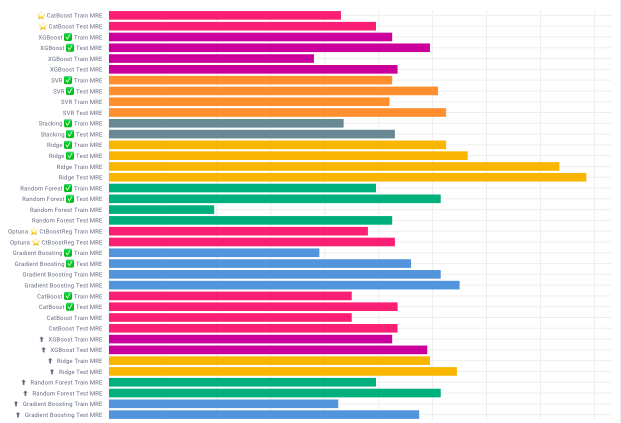

In [16]:
Image("data/from_comet_ml.png")

<blockquote style="font-size: 20px; color: green;">

The best metrics were demonstrated by CatBoostRegression, which was trained on the complete dataset without removing features "condition" and "bathroom_info", and all names of residential complexes were passed as well, as CatBoostRegression can handle a large number of unique categories and explicitly specified missing data, allowing these two features not to be removed. 

Interestingly, the base hyperparameters performed better than after tuning. Therefore, CatBoostRegression with default settings was chosen for serialization.

The baseline model has an error rate of 17%, whereas the selected model reduces this error to 10%, representing an improvement of 7 percentage points compared to the baseline model.
</blockquote>

In [19]:
X_test_ctb.columns

Index(['owner', 'complex_name', 'house_type', 'in_pledge', 'construction_year',
       'ceiling_height', 'bathroom_info', 'condition', 'area', 'room_count',
       'floor', 'floor_count', 'district', 'complex_class', 'parking',
       'elevator', 'schools_within_500m', 'kindergartens_within_500m',
       'park_within_1km', 'distance_to_center', 'distance_to_botanical_garden',
       'distance_to_triathlon_park', 'distance_to_astana_park',
       'distance_to_treatment_facility', 'distance_to_railway_station_1',
       'distance_to_railway_station_2', 'distance_to_industrial_zone',
       'last_floor', 'first_floor'],
      dtype='object')

In [48]:
ctb_reg_full.fit(X_train_ctb, y_train_ctb)

# Evaluate ctb_regressor quality on the test set
y_test_pred = ctb_reg_full.predict(X_test_ctb)

pd.DataFrame({'Test': np.exp(y_test_ctb), 'Pred': np.round(np.exp(y_test_pred))}).head(20)

,Test,Pred
217,21000000,18316716
5589,28000000,24489871
14580,65000000,64860946
13847,22000000,23015404
6863,70000000,65241076
563,23199999,21743365
11548,65000000,85132562
2932,36000000,38618156
3184,33000000,34709014
1862,24500000,25302267


In [ ]:
with open('flask_app/model.pkl', 'wb') as output:
    pickle.dump(ctb_reg_full, output) 

## Functions for downloading and preprocessing new data for model retraining
[[ go back to the top ]](#Table-of-contents)

In [ ]:
def prepare_data_for_model(data):
    """
    Function to prepare data for model training.

    Args:
    - data: DataFrame containing the raw data.

    Returns:
    - X: Features DataFrame for model training.
    - y: Target variable DataFrame for model training.
    """
    # Calculate logarithm of price
    data['log_price'] = np.log(data['price'])

    # Process ceiling height
    data['ceiling_height'] = data['ceiling_height'].apply(process_ceiling_height)

    # Limit number of schools within 500m to 4
    data['schools_within_500m'] = data['schools_within_500m'].apply(lambda x: min(x, 4))

    # Limit number of kindergartens within 500m to 3
    data['kindergartens_within_500m'] = data['kindergartens_within_500m'].apply(lambda x: min(x, 3))

    # Drop unnecessary columns
    data.drop(['name', 'information', 'address', 'price', 'coordinates', 'kzt_sq_m'], axis=1, inplace=True)

    # Fill missing values in 'condition' and 'bathroom_info' columns with -999
    data['condition'] = data['condition'].fillna(-999)
    data['bathroom_info'] = data['bathroom_info'].fillna(-999)

    # Drop rows with missing values and reset index
    data = data.dropna().reset_index(drop=True)

    # Split data into features (X) and target variable (y)
    X = data.drop(columns=['log_price'])
    y = data['log_price']
    
    return X, y


def data_processing_pipeline(total_pages=1000, random_state=42):
    """
    Function to perform the entire data processing pipeline.

    Args:
    - total_pages: Total number of pages for data parsing.
    - random_state: Random seed for reproducibility.

    Returns:
    - X: Features DataFrame for model training.
    - y: Target variable DataFrame for model training.
    """
    # Parse additional data
    data = parsing_addition_data(total_pages)

    # Geo-process data
    data = geo_process_krisha_df(data)

    # Fill complex names
    data = filling_complex_names_in_krisha_df(data)

    # Merge dataframes
    data = merge_dataframes(data)

    # Process and clean data
    data = process_and_clean_data(data)

    # Geo-preprocess merged data
    data = geo_preprocess_merged_df(data)

    # Create additional features
    data = create_additional_features(data)

    # Perform manual data imputation
    data = manual_data_imputation(data)

    # Fill missing values using Random Forest Classifier
    data = fill_missing_by_rfc(data, random_state)

    # Remove outliers
    data = remove_outliers(data)

    # Process ceiling height
    data = process_ceiling_height(data)

    # Adjust ceiling height
    data = adjust_ceiling_height(data)

    # Prepare data for model training
    X, y = prepare_data_for_model(data)

    return X, y


[[ go back to the top ]](#Table-of-contents)